In [1]:
import os
import random
from datetime import datetime
import ast

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

from preprocessing.default_preprocessing import serve_data
from preprocessing.house_zero_preprocessing import serve_data_hz

from models.transformer_encoder import TransEncoder
from models.baseline import BaseLineModel
from models.context_unet import ContextUnet

from ddpm.ddpm import GaussianDiffusion1D

from evaluation.pca_tsne import visualize_pca_tsne
from evaluation.jsd import compute_jsd

random.seed(42)
np.random.seed(42)

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

0

# Parameters

In [3]:
config_path = "./config.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
subset_len = config["subset_len"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])
dataset_name = config["dataset"]
house_zero_feature_subset = config["house_zero_feature_subset"]

assert model_name in ["BaseLine", "TransEncoder"], "Chosen  model was not valid, the options are BaseLine or TransEncoder"
assert cond_model in {"mlp", "te", "fft", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te, fft and stft"

log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"

# Data

In [4]:
train_loader, test_loader, features, cond_features = serve_data(seq_len, batch_size_config, dataset_name)

num of channels in transformer: 8 
num of cond feature: 8
Train shape (batch, features, seq_len): (14024, 8, 15)
Cond shape (batch, features, seq_len): (14024, 8, 15)
batched data shape: torch.Size([32, 8, 15])


# Model

In [5]:
if model_name == "TransEncoder":
    model = model = TransEncoder(features = features, latent_dim = latent_dim,num_heads = n_heads, num_layers = num_layers, cond_features=cond_features, cond_model=cond_model, device=device)
if model_name == "BaseLine":
    model = BaseLineModel(input_size=seq_len, hidden_size=latent_dim, cond_features=cond_features, cond_model=cond_model, device=device, channels=features)
 
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr, betas = betas)
writer = SummaryWriter(tb_writer)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Train

In [6]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

lowest_loss = 100000
step=0
for running_epoch in tqdm(range(epochs)):
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
                
        batch_size = data.shape[0]
        
        optim.zero_grad()

        loss = ddpm(data, cond_data)
        loss.backward()
        
        optim.step()
        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Training Loss", loss, global_step=step)
        step += 1
        
    if i%len(train_loader)== 0 and running_epoch%10==0:
        print(f'Epoch: {running_epoch+1}, Loss: {loss.item()}')

    if running_epoch % save_rate == 0:
        torch.save({
            'epoch': running_epoch+1,
            'diffusion_state_dict': ddpm.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'{running_epoch}_weights.pth'))

torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

100%|██████████| 4/4 [00:20<00:00,  5.19s/it]


## Sampling

In [7]:
with torch.no_grad():
    samples = ddpm.sample(batch_size_config)
    samples = samples.cpu().numpy()
    samples = samples.transpose(0, 2, 1)

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:03<00:00, 280.23it/s]

Samples shape: (32, 15, 8)


# Evaluation
## Without Conditioning
### Train

In [8]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([32, 8, 15]), torch.Size([32, 8, 15]))

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


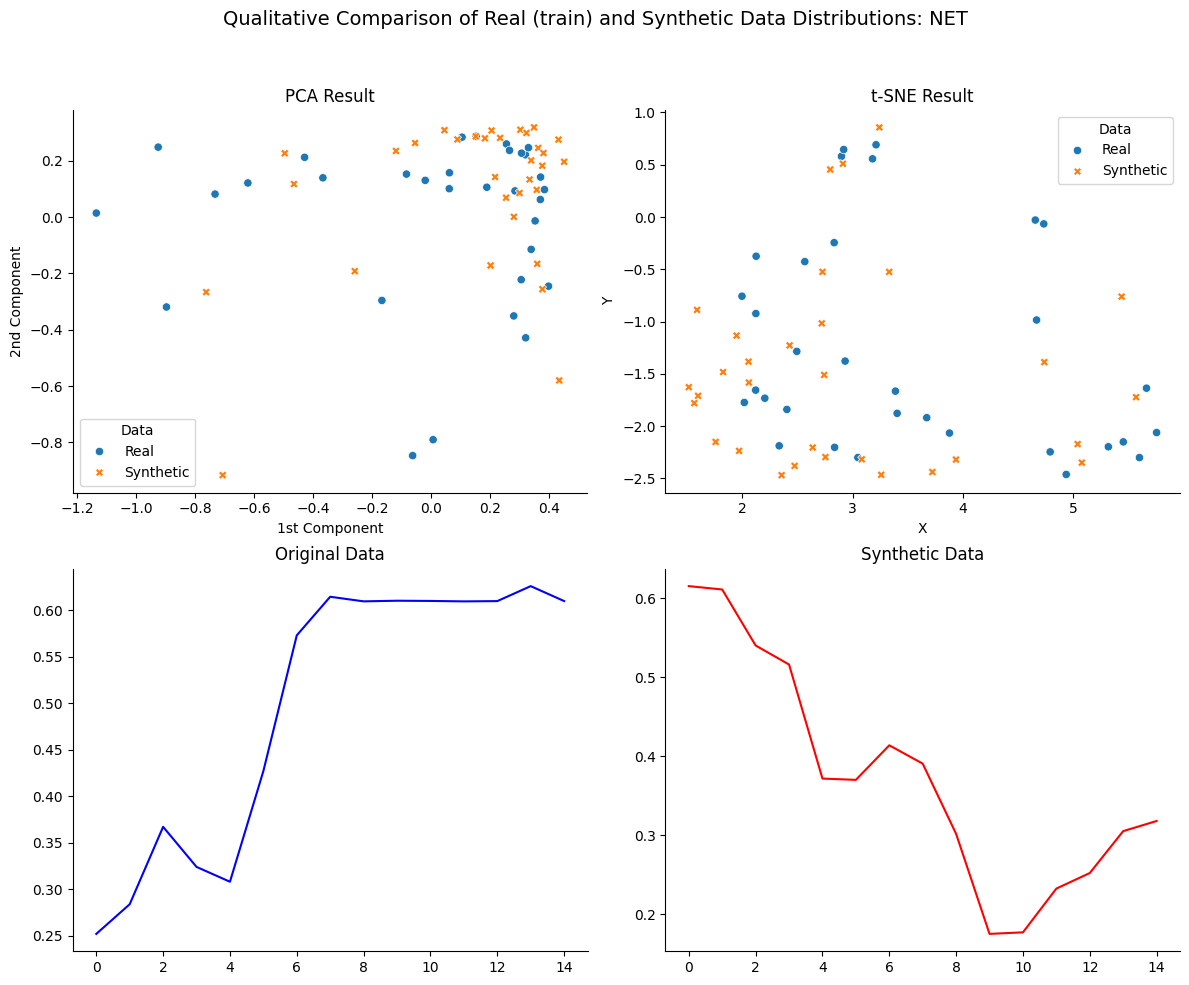

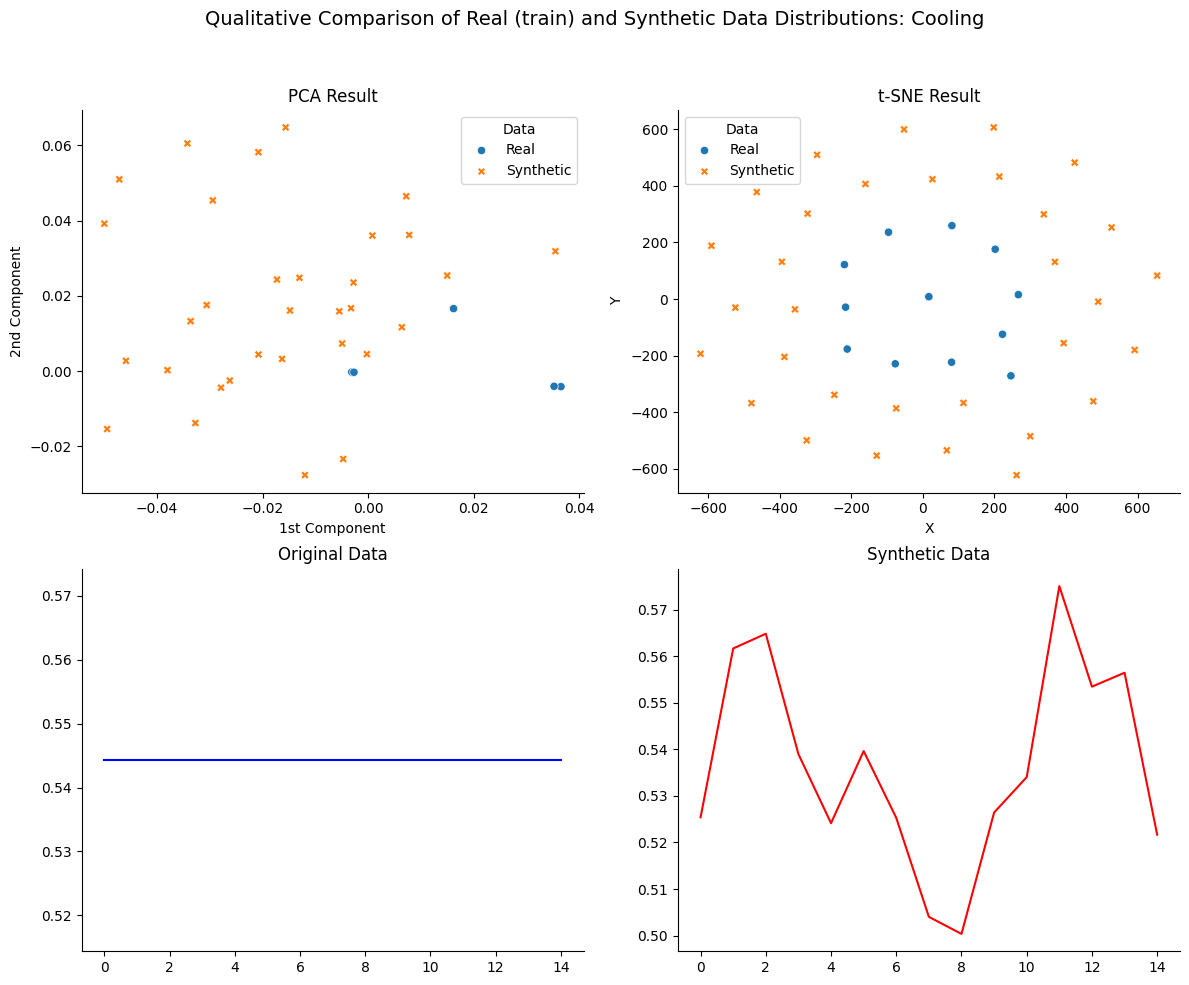

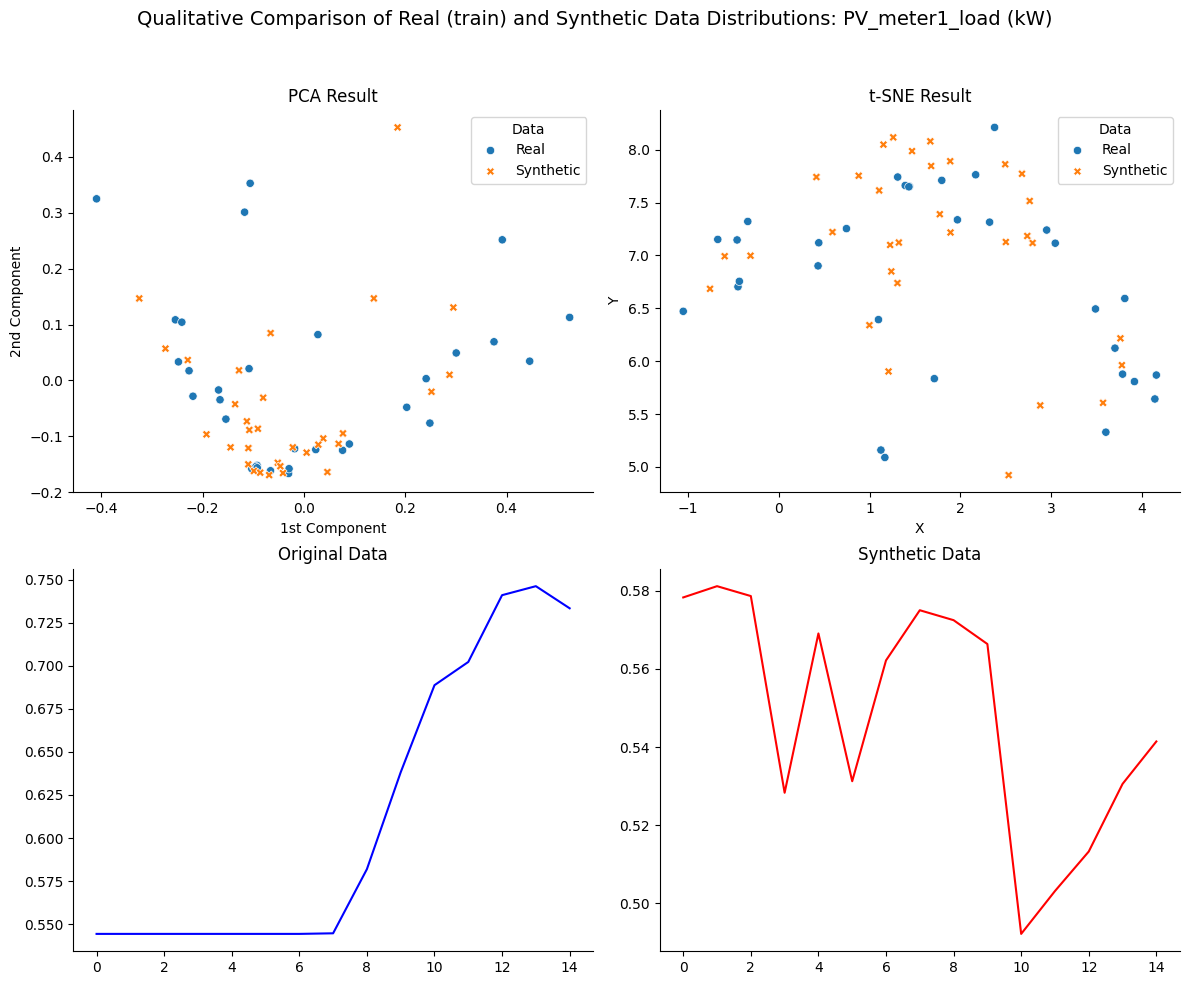

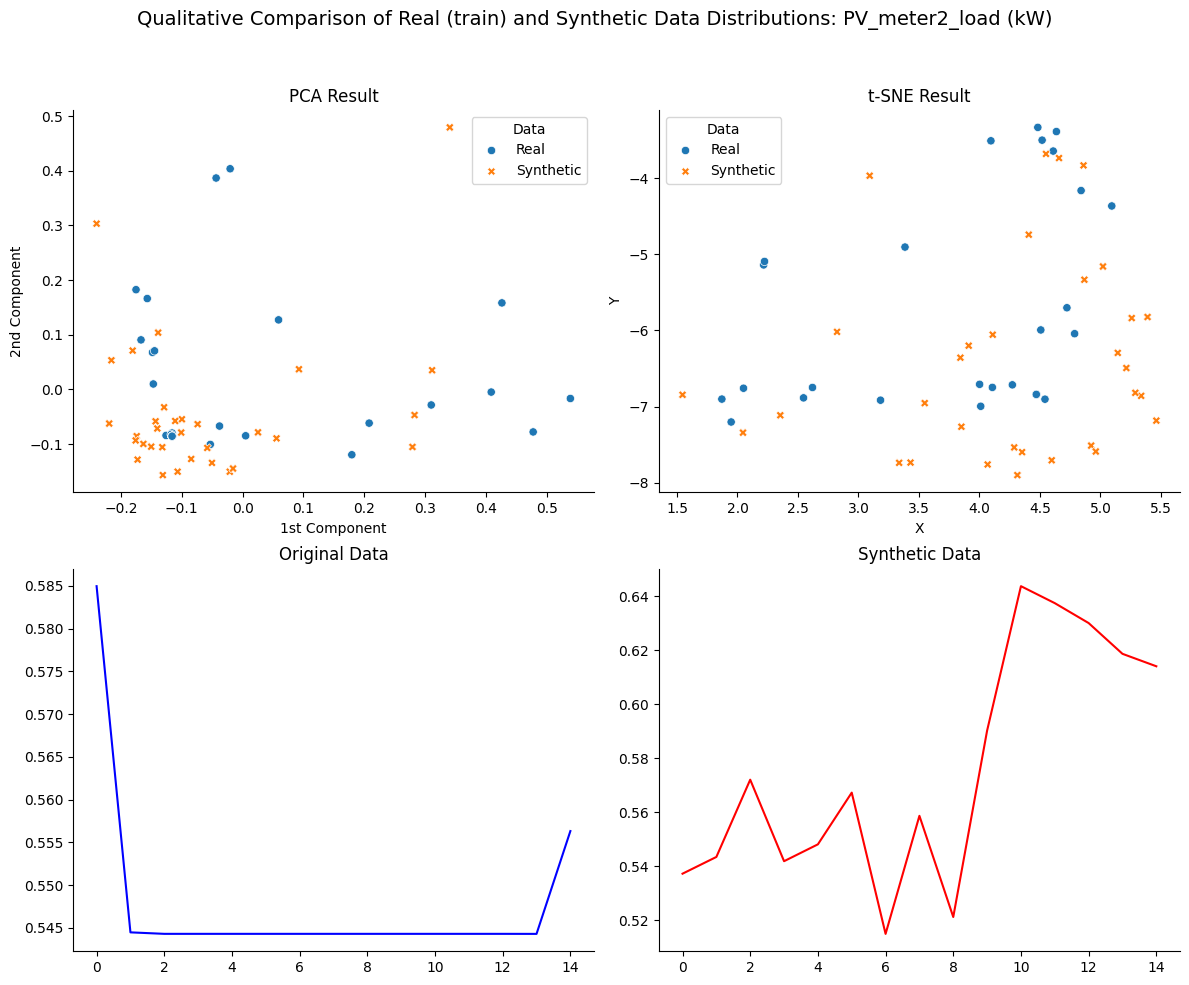

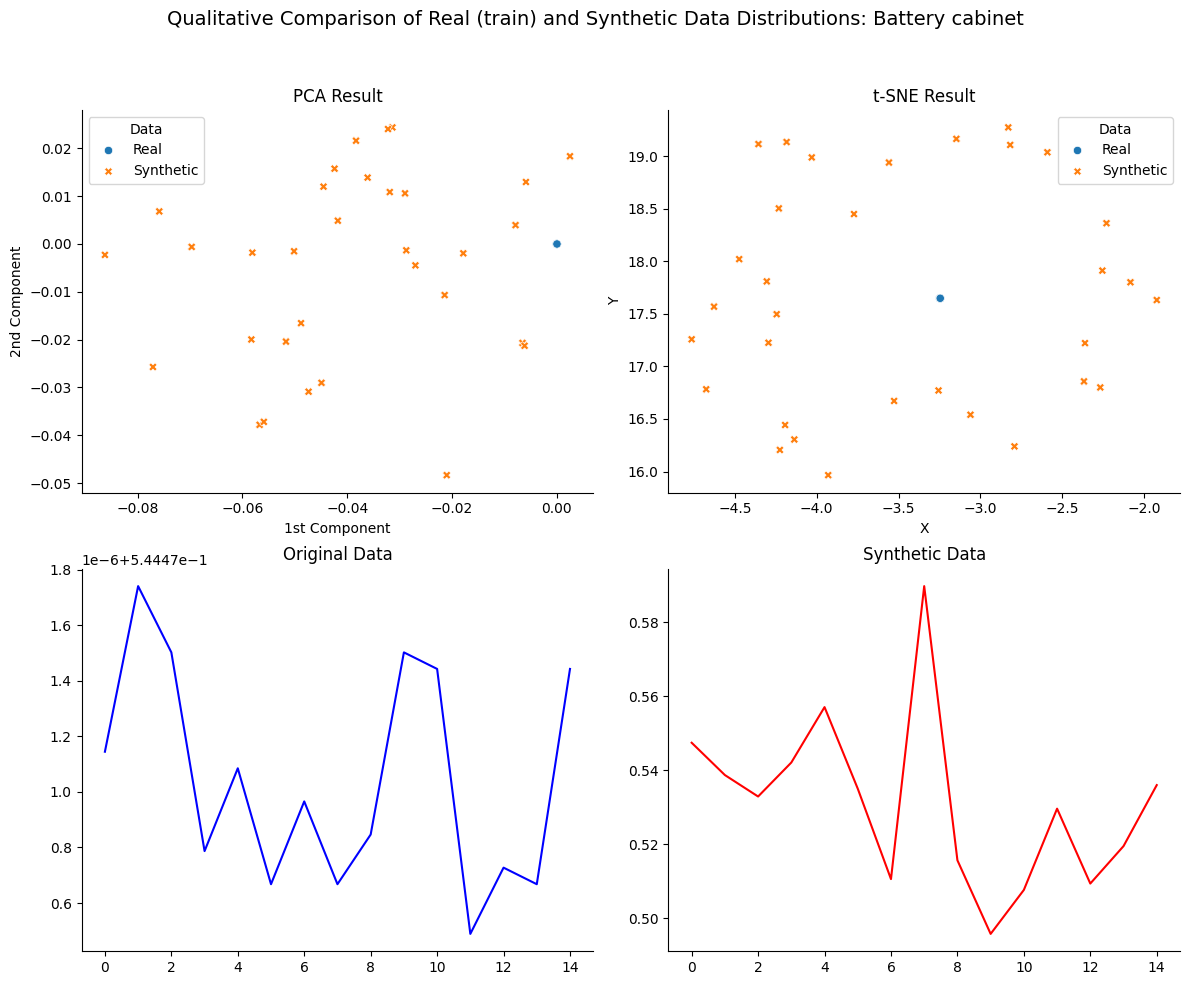

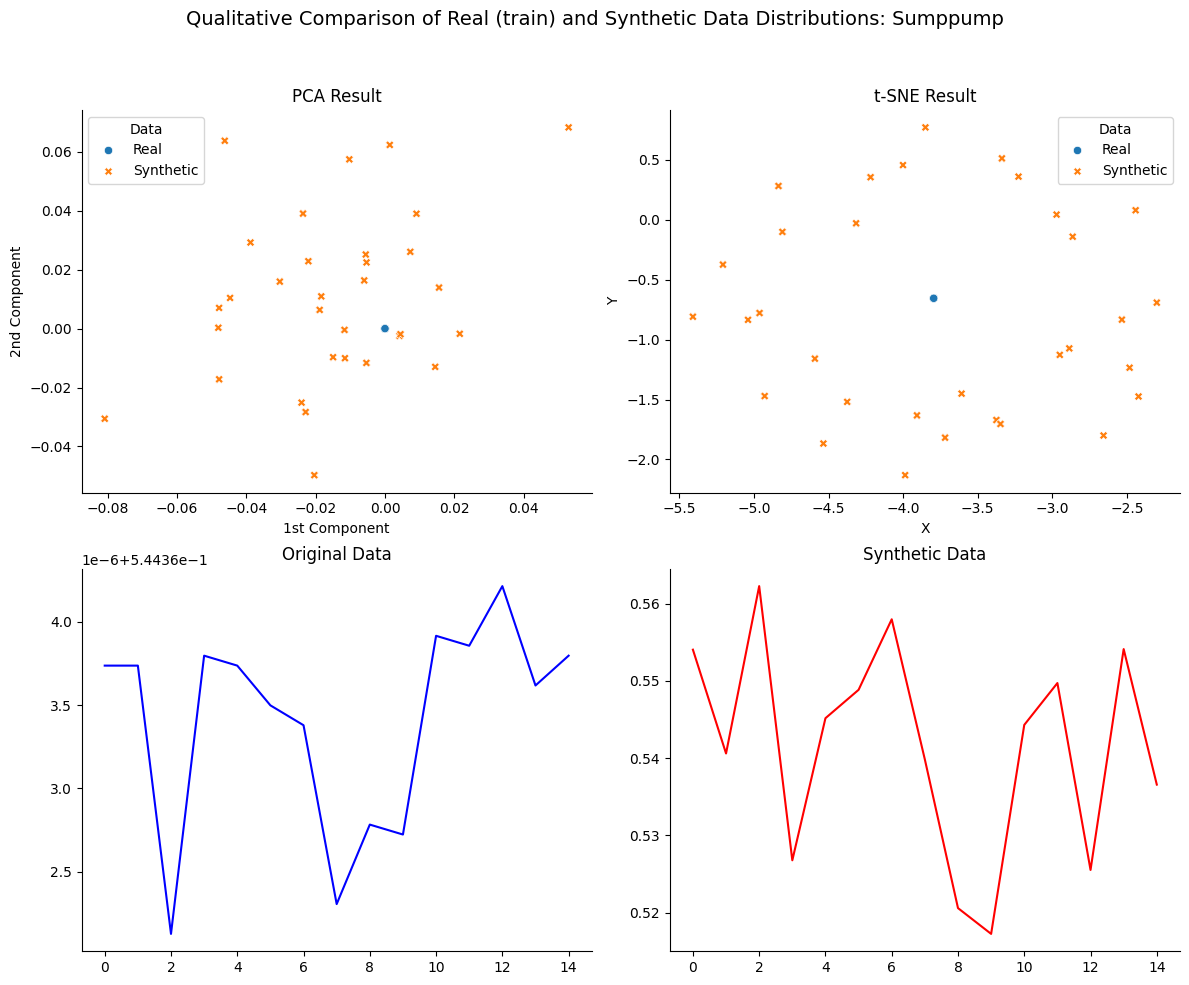

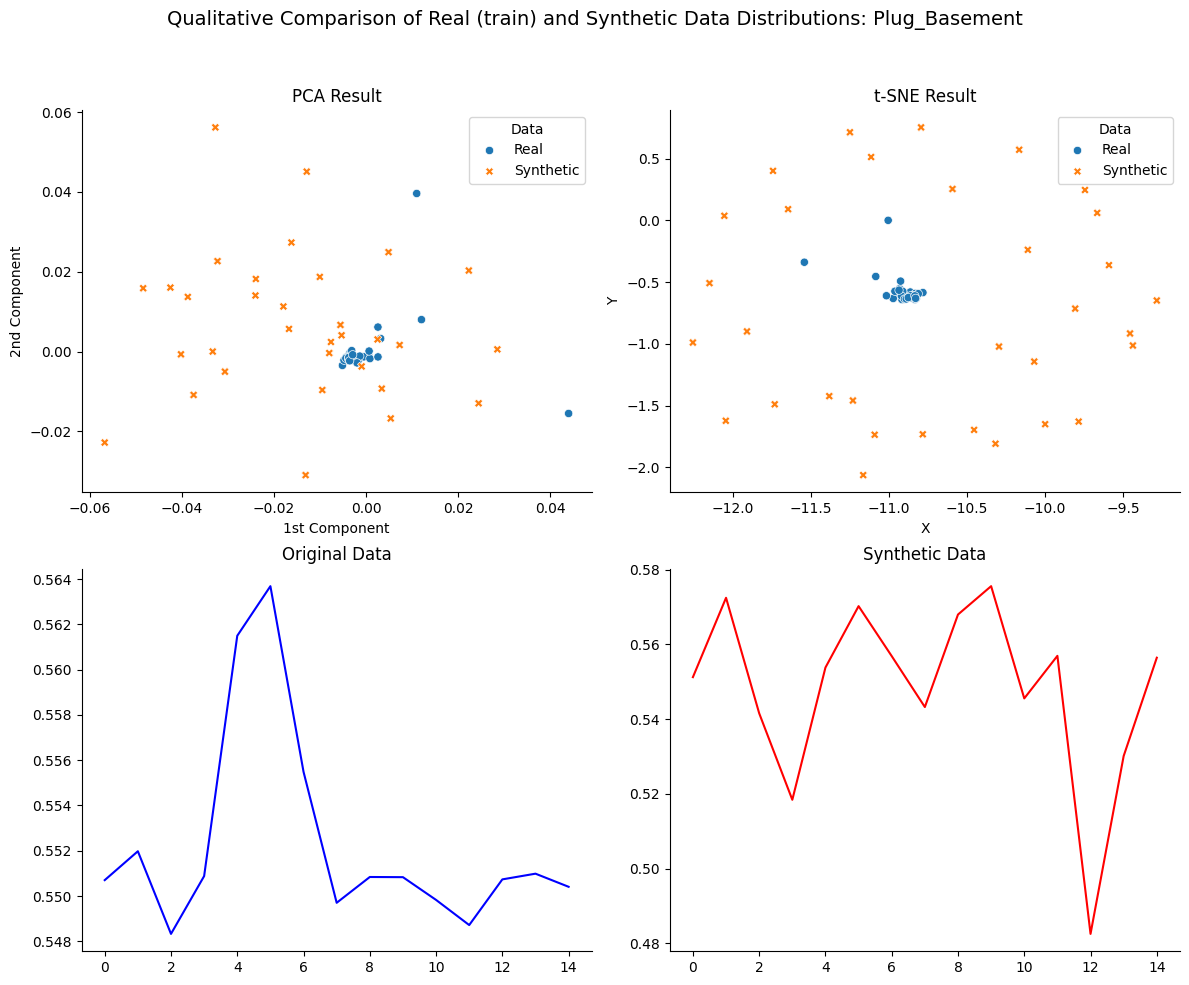

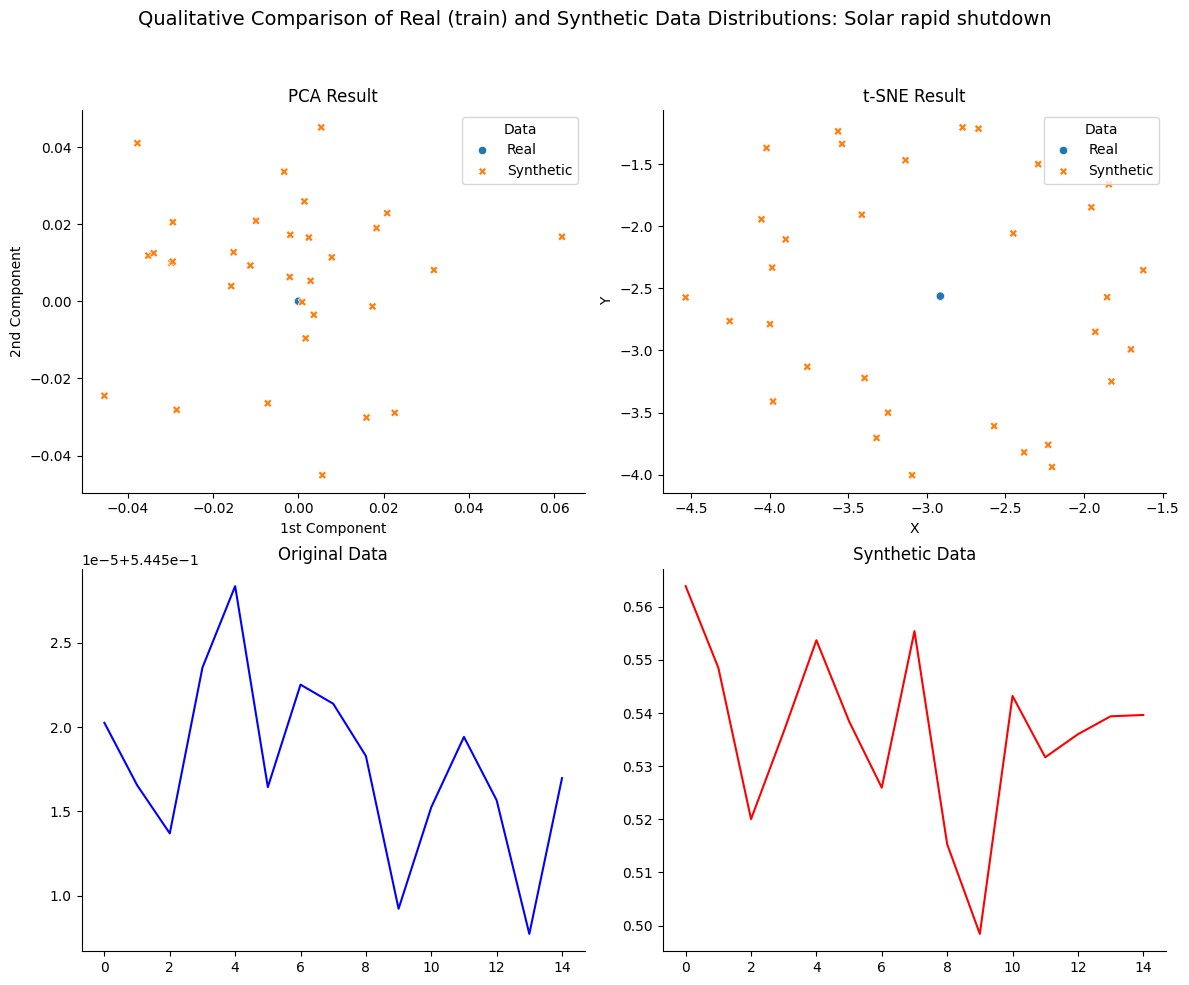

In [9]:
for idx, feature in enumerate(house_zero_feature_subset):
    real_feature = np.expand_dims(real_data_train[:, idx, :].cpu().numpy(), axis=-1)
    gen_feature = np.expand_dims(samples[:, :, idx], axis=-1)
    
    visualize_pca_tsne(ori_data=real_feature, fake_data=gen_feature, seq_len=seq_len, train_test="train", filename=log_file_name, cond=False, feature=feature)

### Test

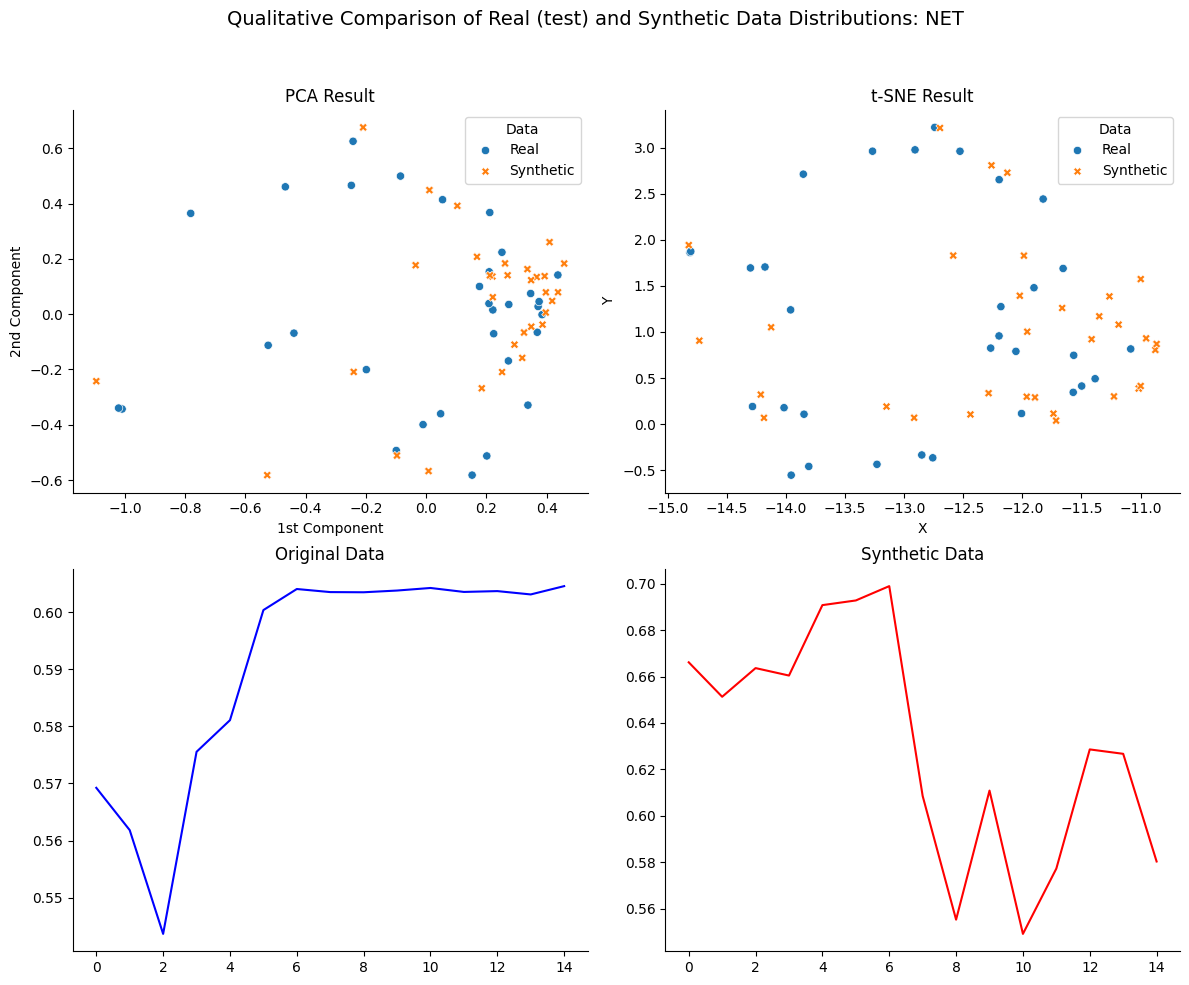

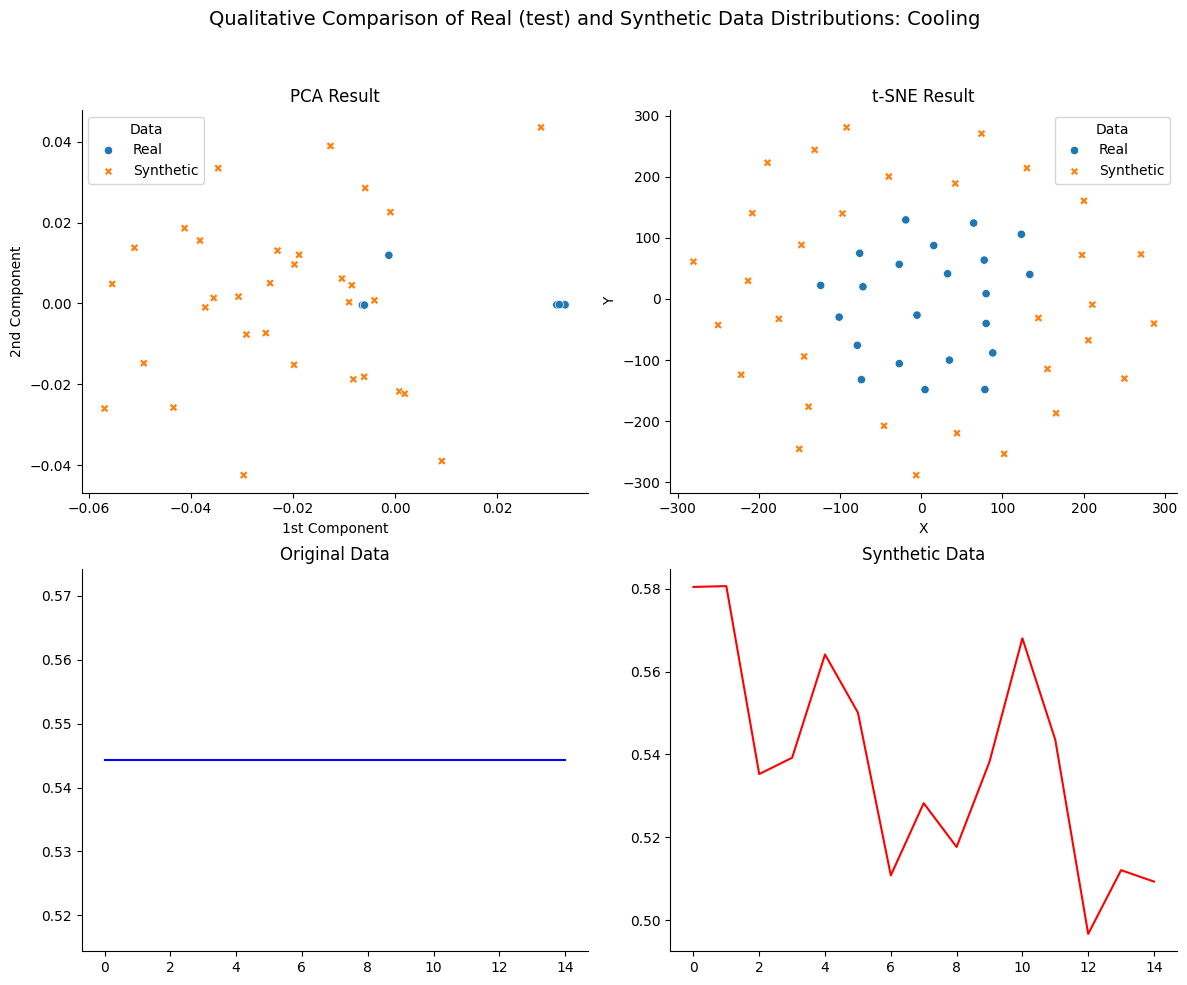

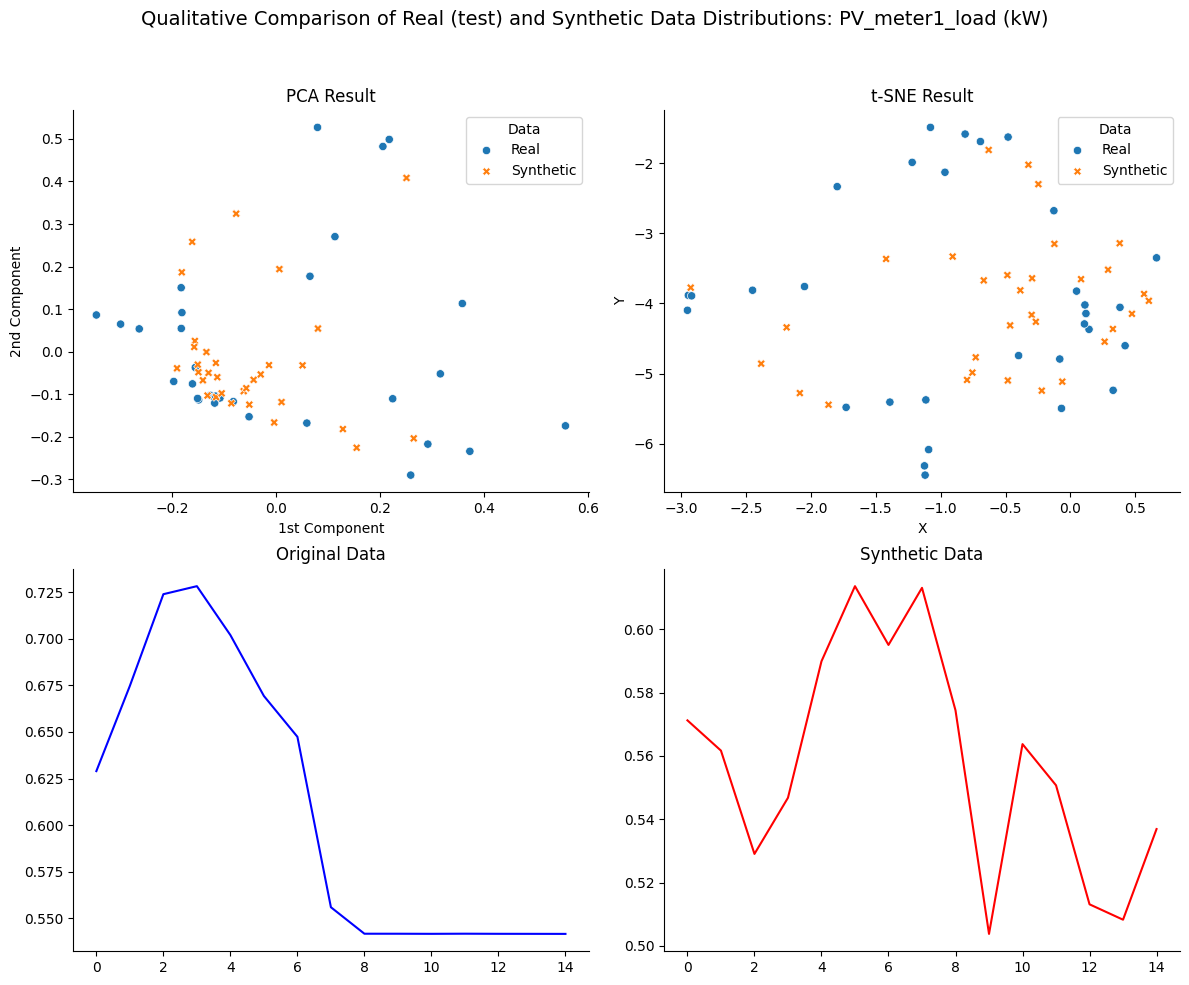

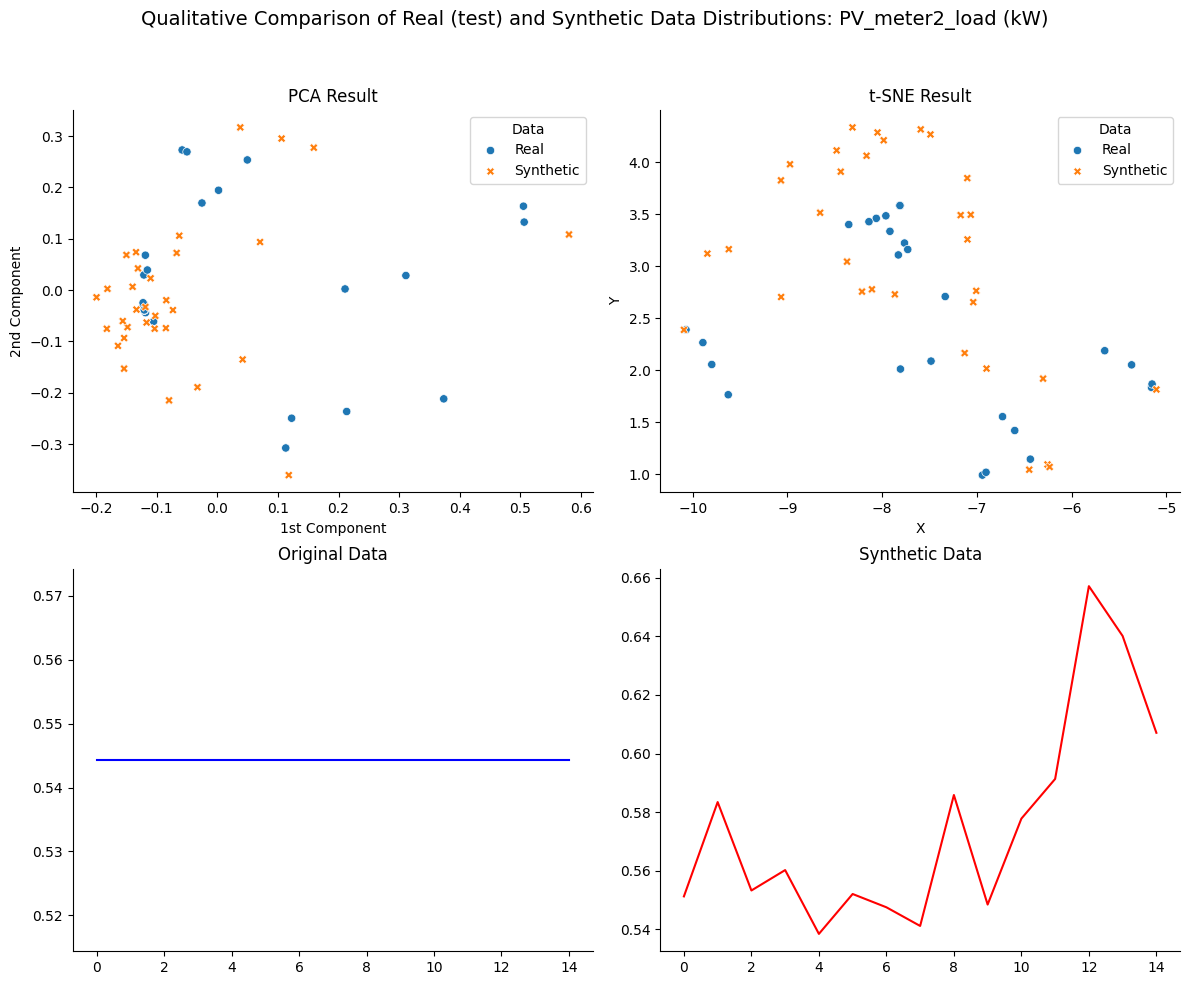

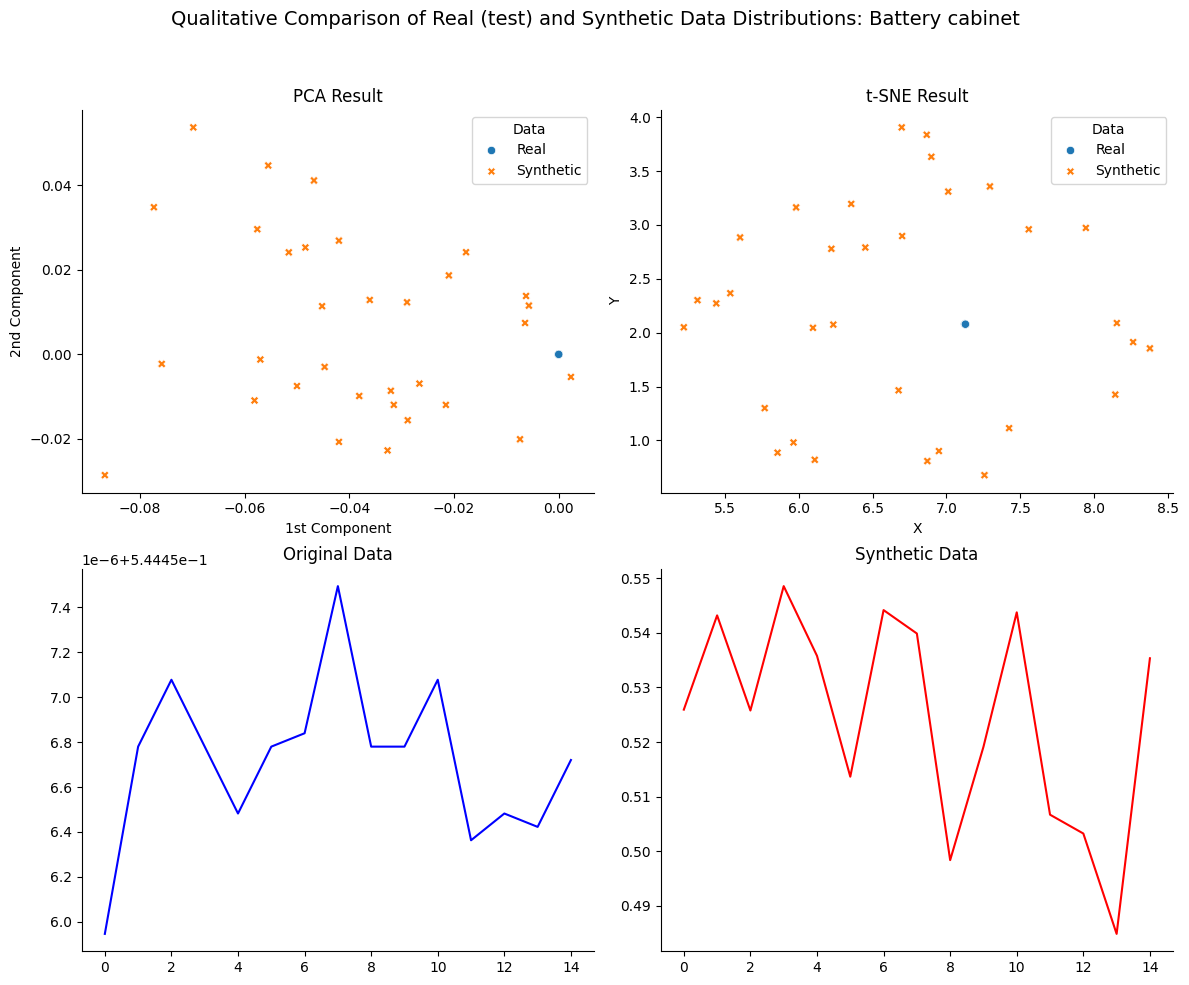

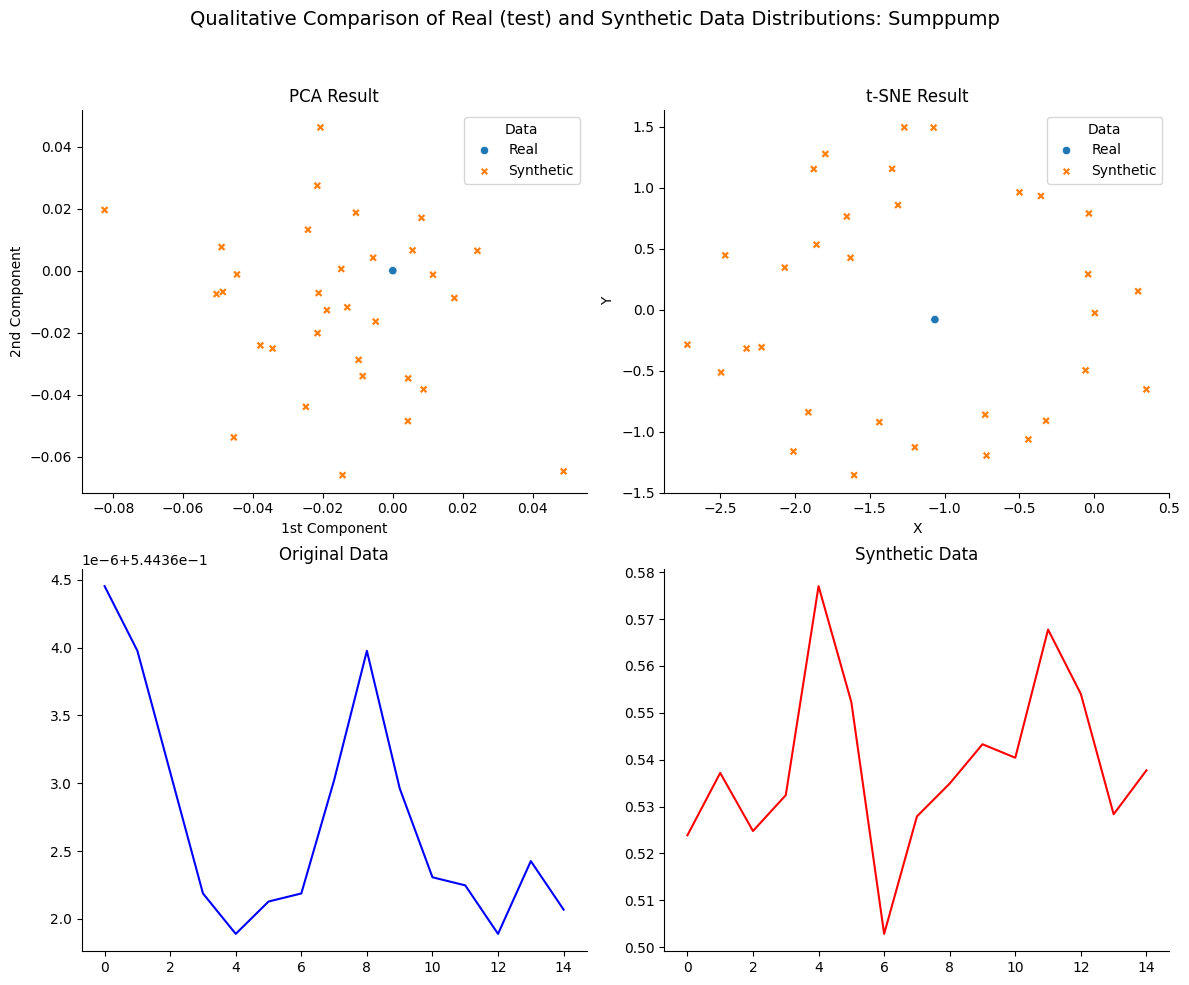

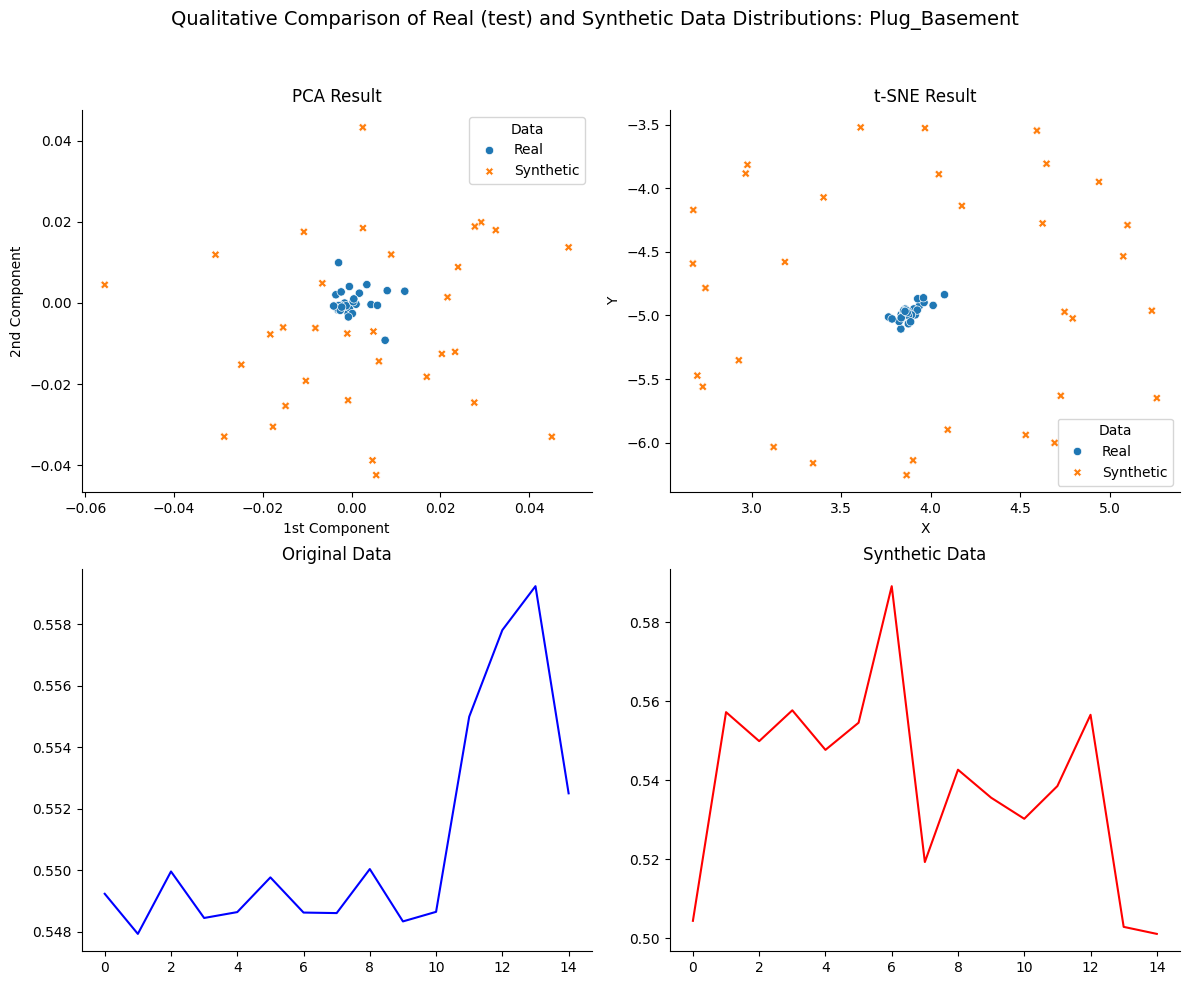

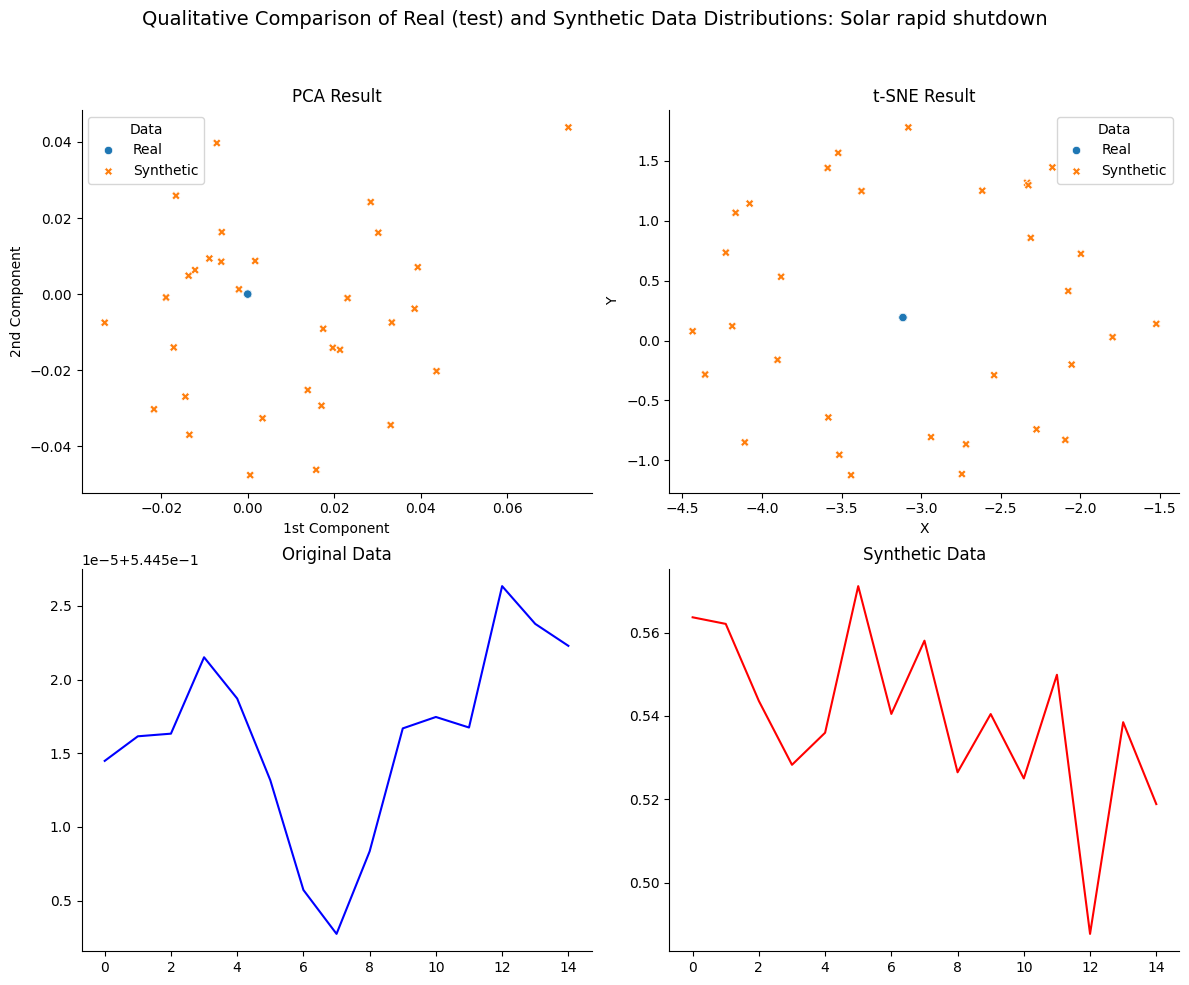

In [10]:
for idx, feature in enumerate(house_zero_feature_subset):
    real_feature = np.expand_dims(real_data_test[:, idx, :].cpu().numpy(), axis=-1)
    gen_feature = np.expand_dims(samples[:, :, idx], axis=-1)
    
    visualize_pca_tsne(ori_data=real_feature, fake_data=gen_feature, seq_len=seq_len, train_test="test", filename=log_file_name, cond=False, feature=feature)

### Jensen-Shannon Divergence

In [11]:
train_jsd_no_con_list = []
test_jsd_no_con_list = []

for idx, feature in enumerate(house_zero_feature_subset):
    real_feature_train = real_data_train[:, idx, :].cpu().numpy()
    real_feature_test = real_data_test[:, idx, :].cpu().numpy()
    gen_feature = samples[:, :, idx]
    
    jsd_no_con_train = compute_jsd(real_feature_train, samples)
    jsd_no_con_test = compute_jsd(real_feature_test, samples)
    
    train_jsd_no_con_list.append(jsd_no_con_train)
    test_jsd_no_con_list.append(jsd_no_con_test)

## With Conditioning

In [12]:
with torch.no_grad():
    cond_samples_train = ddpm.sample(real_cond_data_train.shape[0], real_cond_data_train.to(device))
    cond_samples_train = cond_samples_train.cpu().numpy()
    cond_samples_train = cond_samples_train.transpose(0, 2, 1)

print(f"Samples shape: {cond_samples_train.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:03<00:00, 260.74it/s]

Samples shape: (32, 15, 8)


### T-SNE and PCA

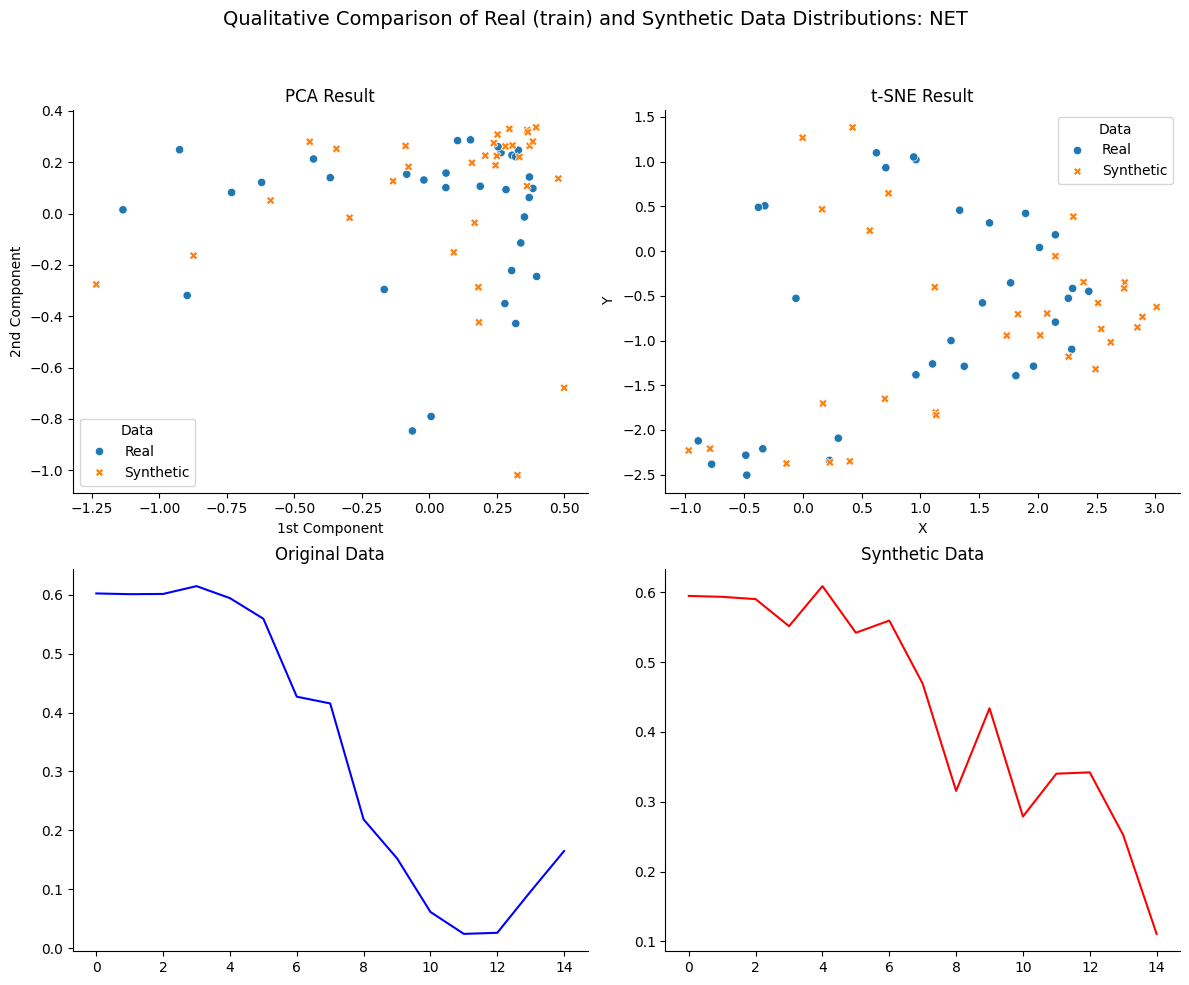

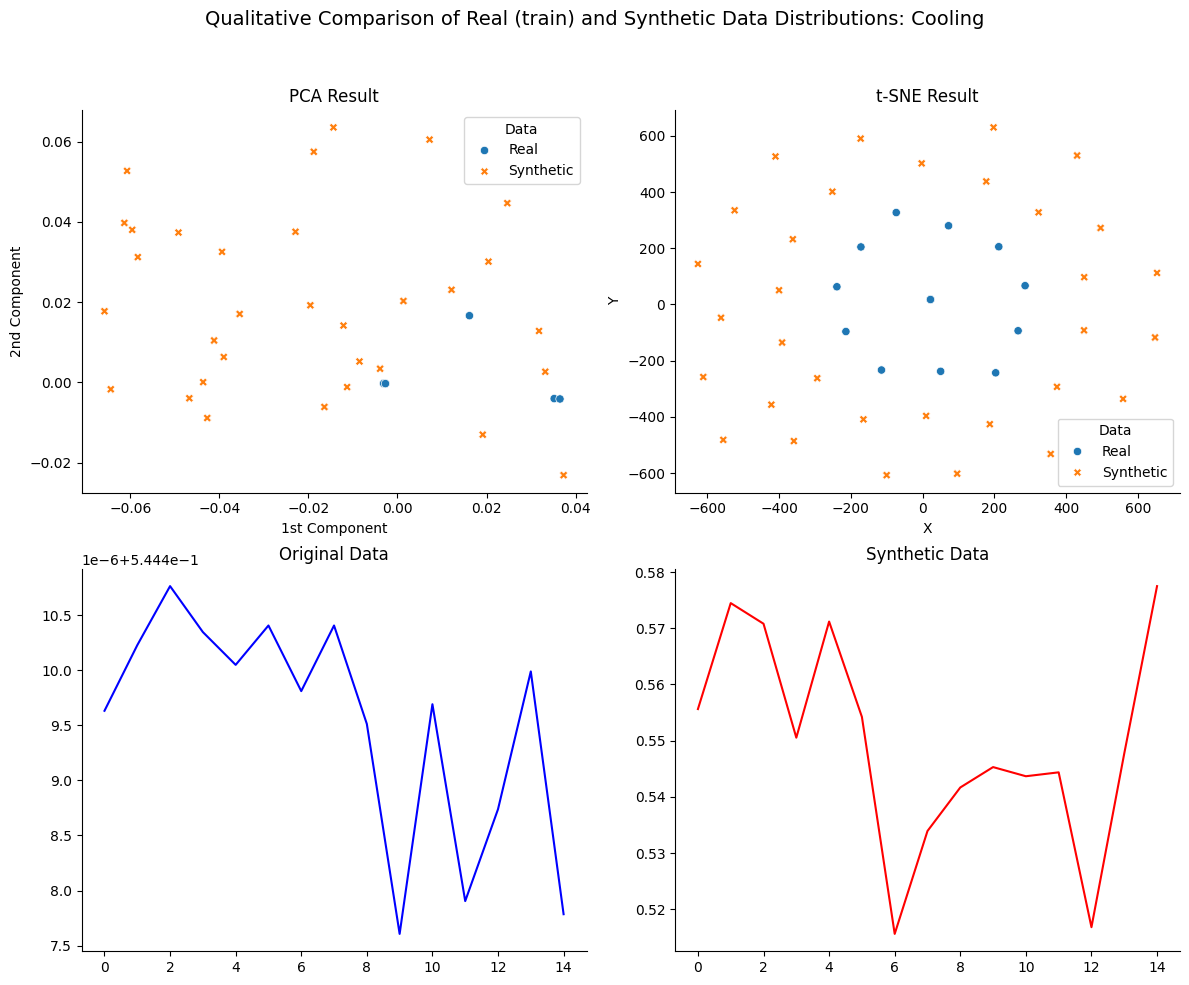

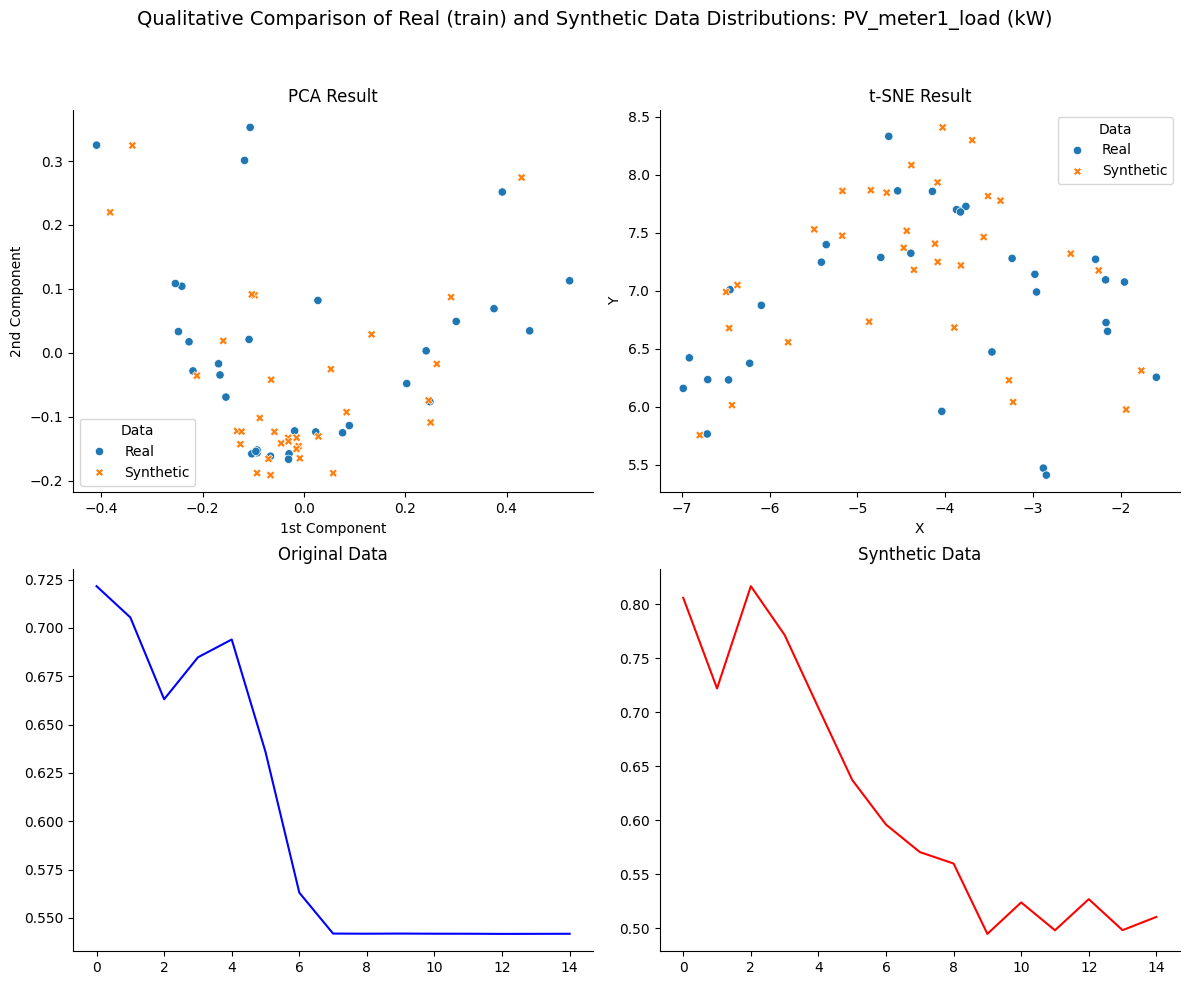

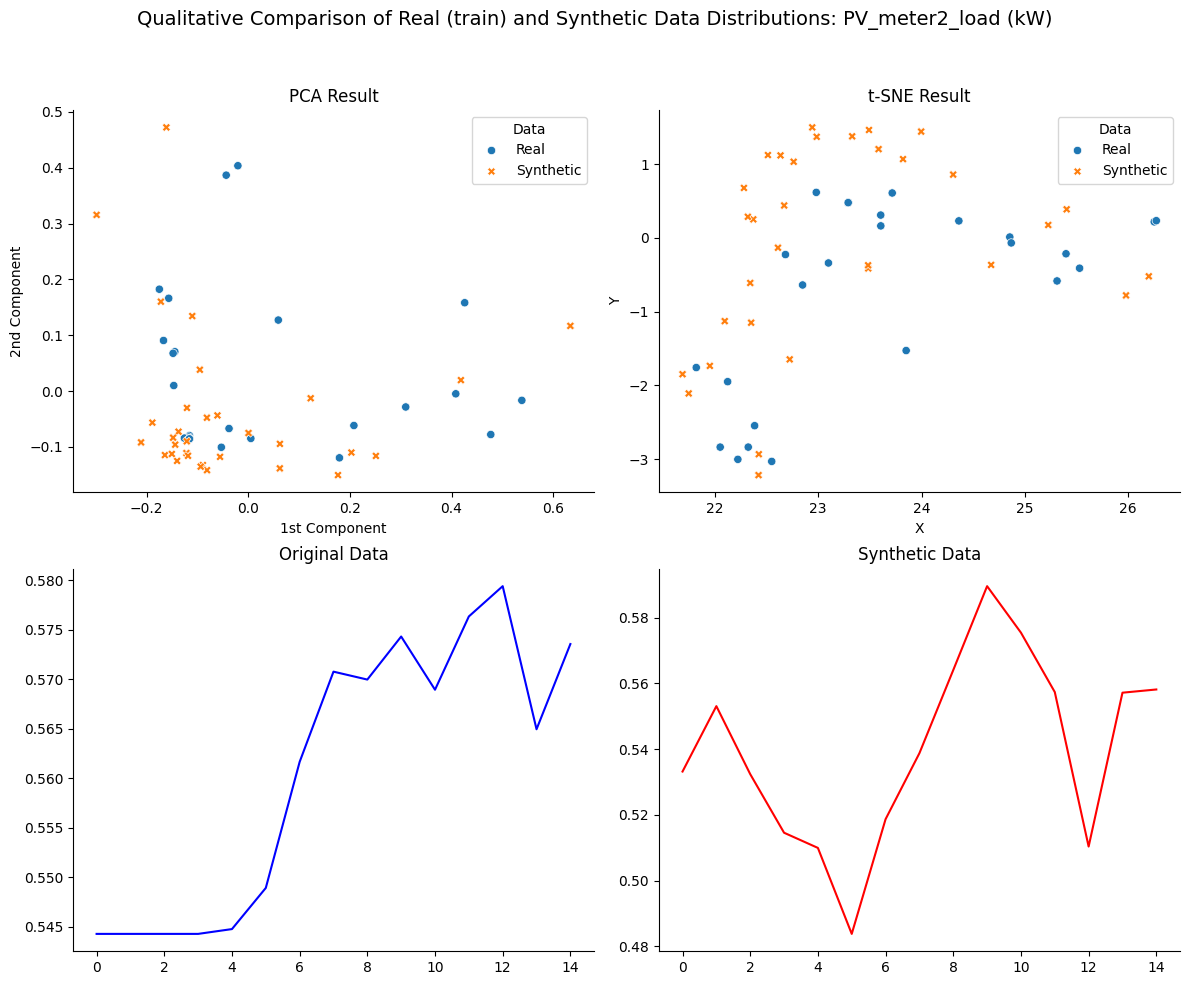

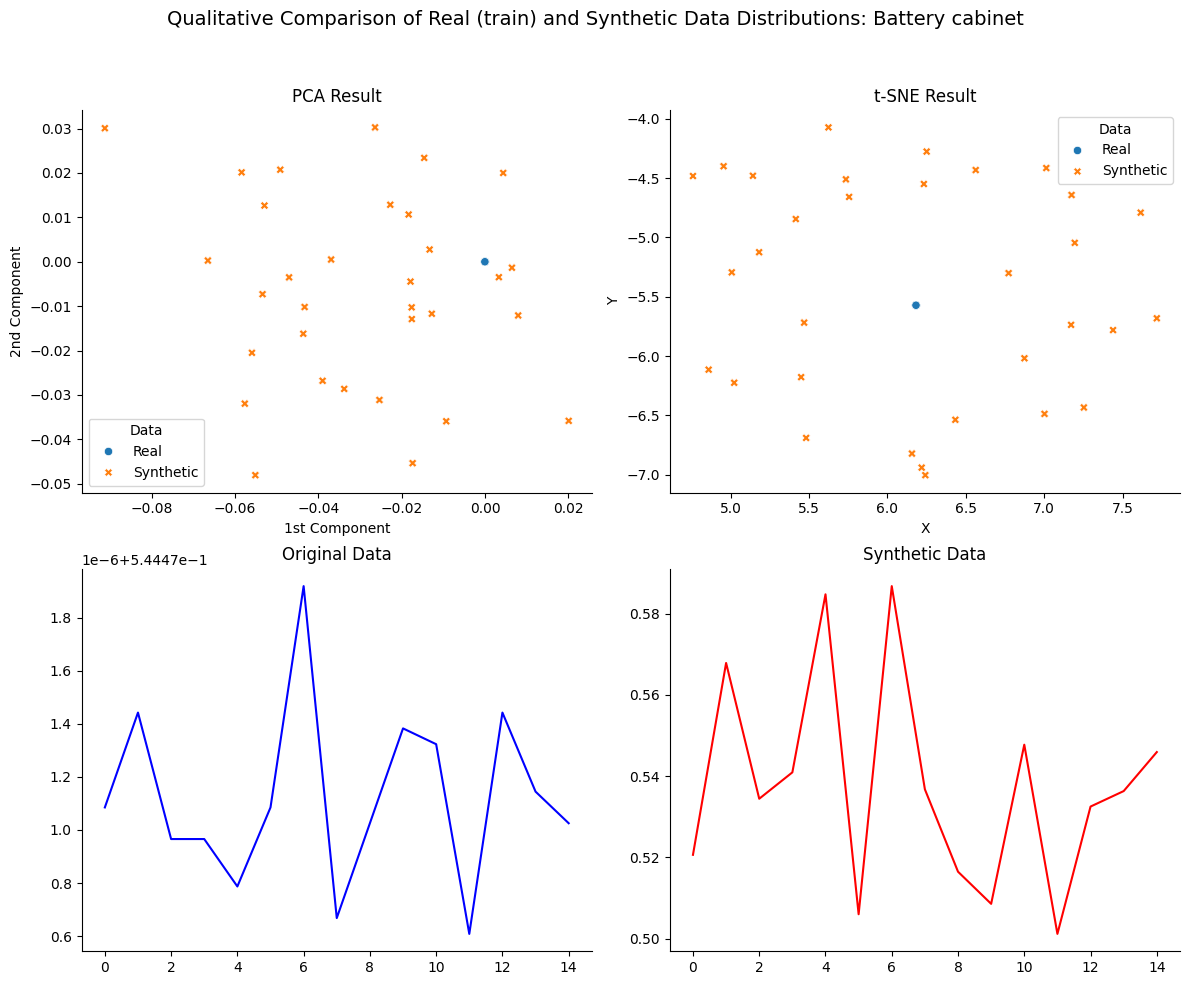

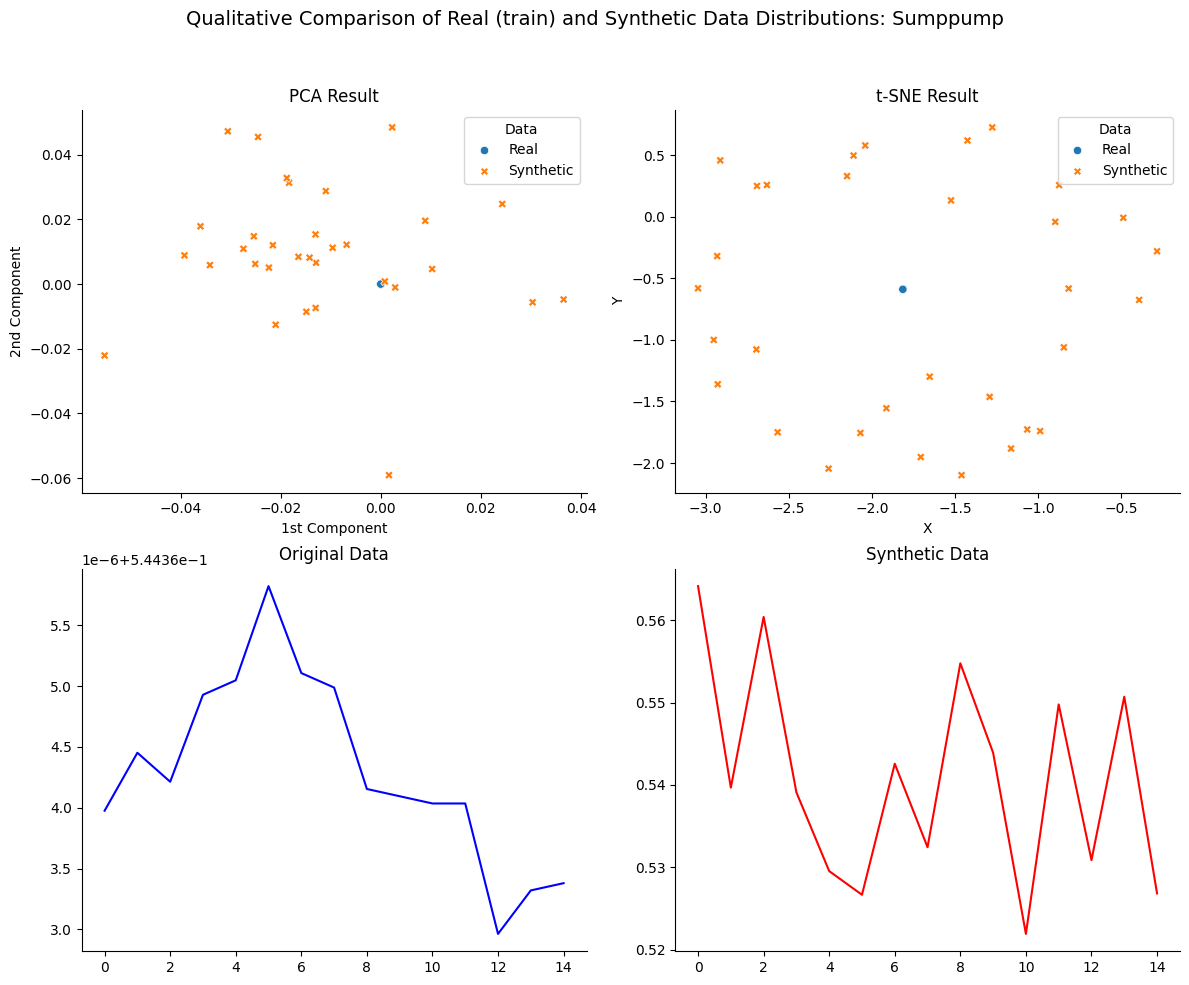

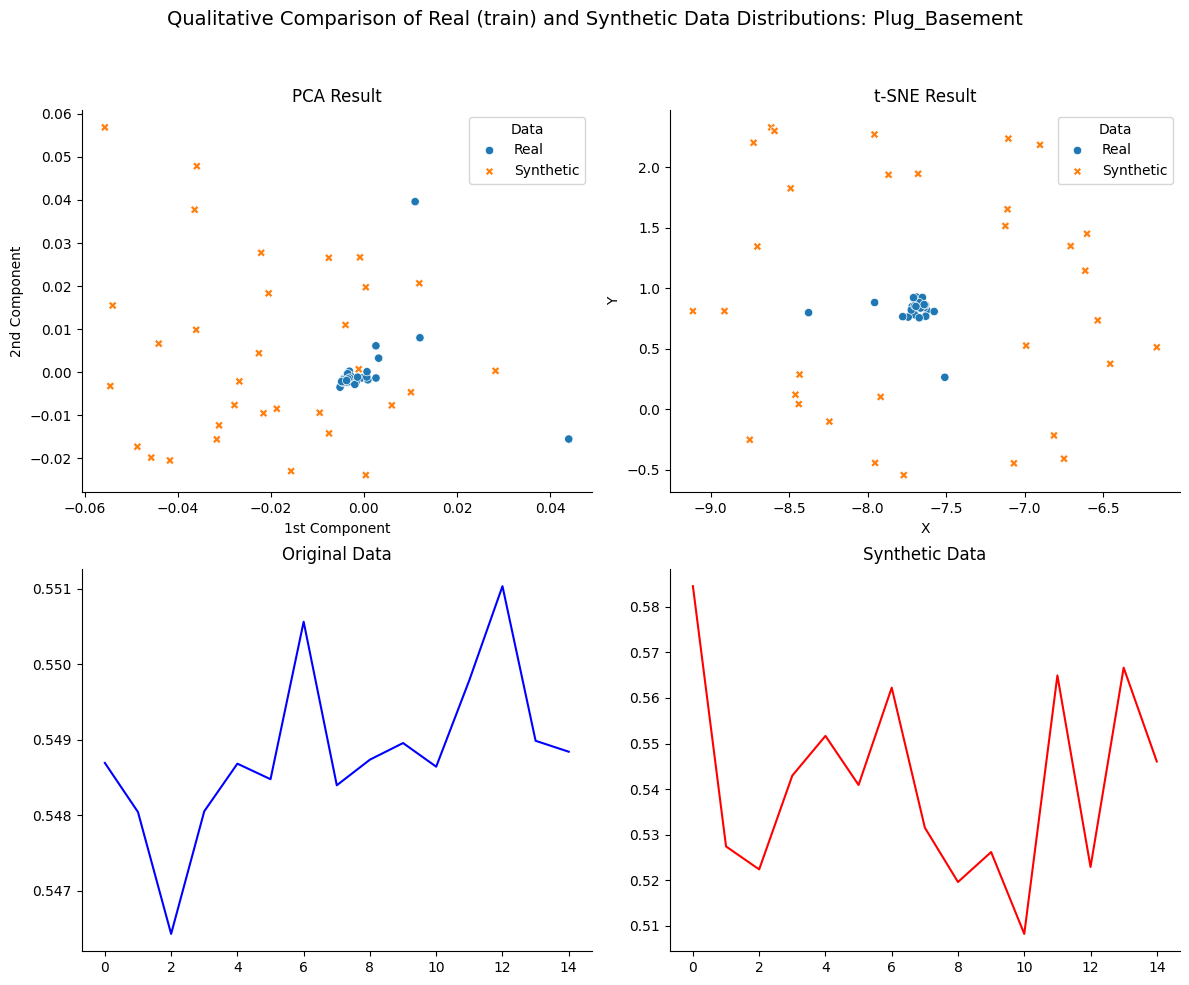

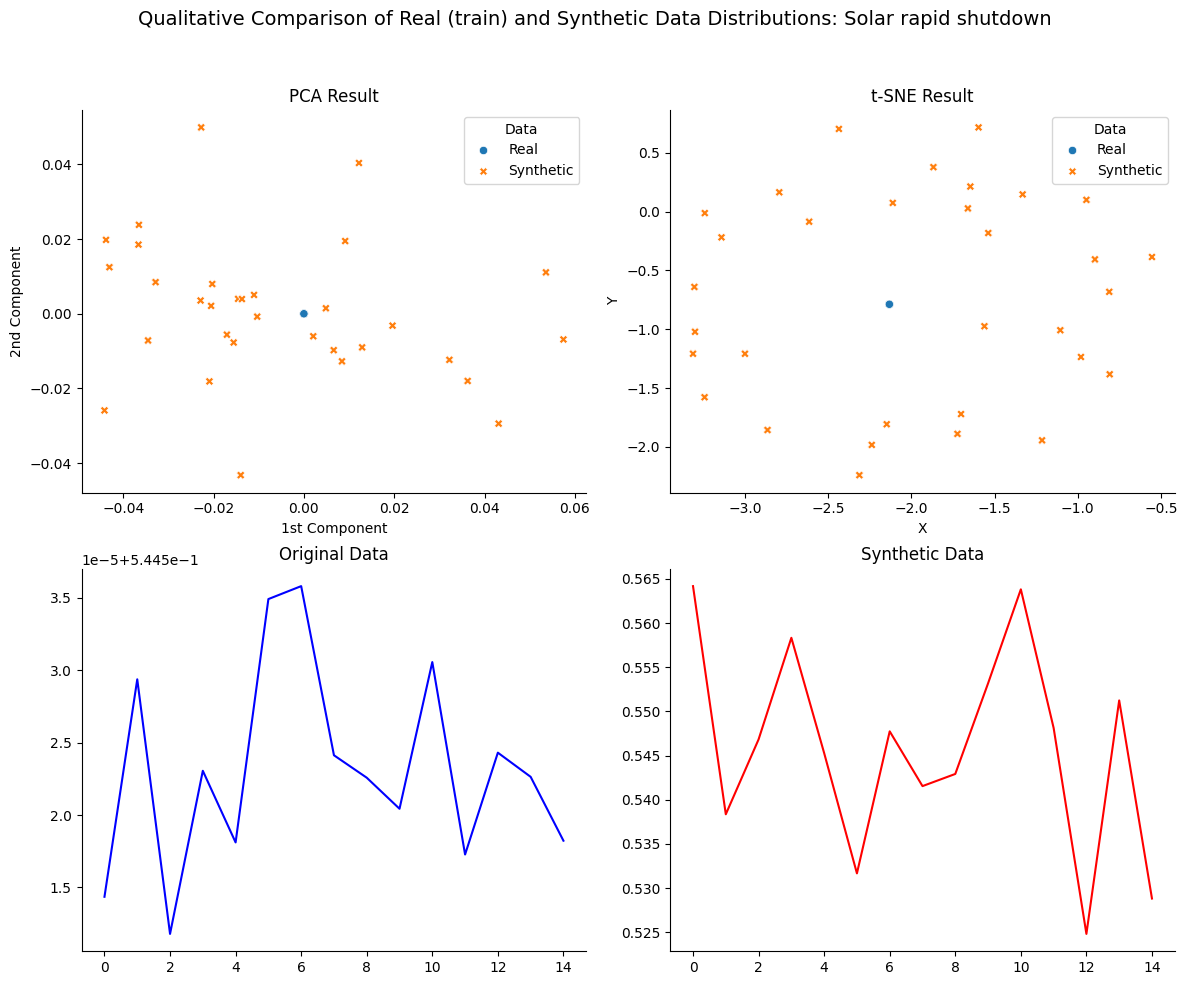

In [13]:
for idx, feature in enumerate(house_zero_feature_subset):
    real_feature = np.expand_dims(real_data_train[:, idx, :].cpu().numpy(), axis=-1)
    gen_feature = np.expand_dims(cond_samples_train[:, :, idx], axis=-1)
    
    visualize_pca_tsne(ori_data=real_feature, fake_data=gen_feature, seq_len=seq_len, train_test="train", filename=log_file_name, cond=True, feature=feature)

In [14]:
with torch.no_grad():
    cond_samples_test = ddpm.sample(real_cond_data_test.shape[0], real_cond_data_test.to(device))
    cond_samples_test = cond_samples_test.cpu().numpy()
    cond_samples_test = cond_samples_test.transpose(0, 2, 1)

print(f"Samples shape: {cond_samples_test.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:03<00:00, 269.01it/s]

Samples shape: (32, 15, 8)


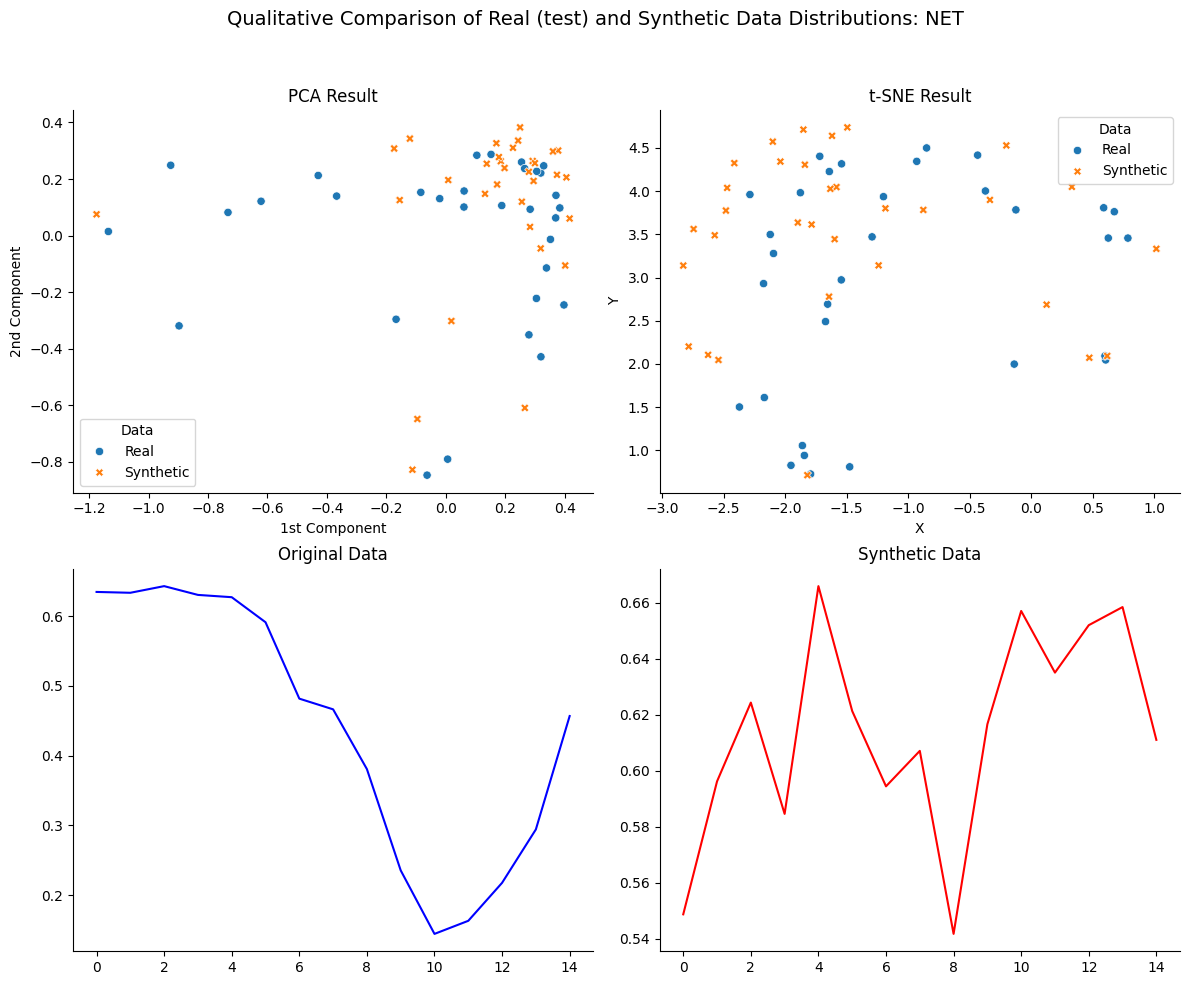

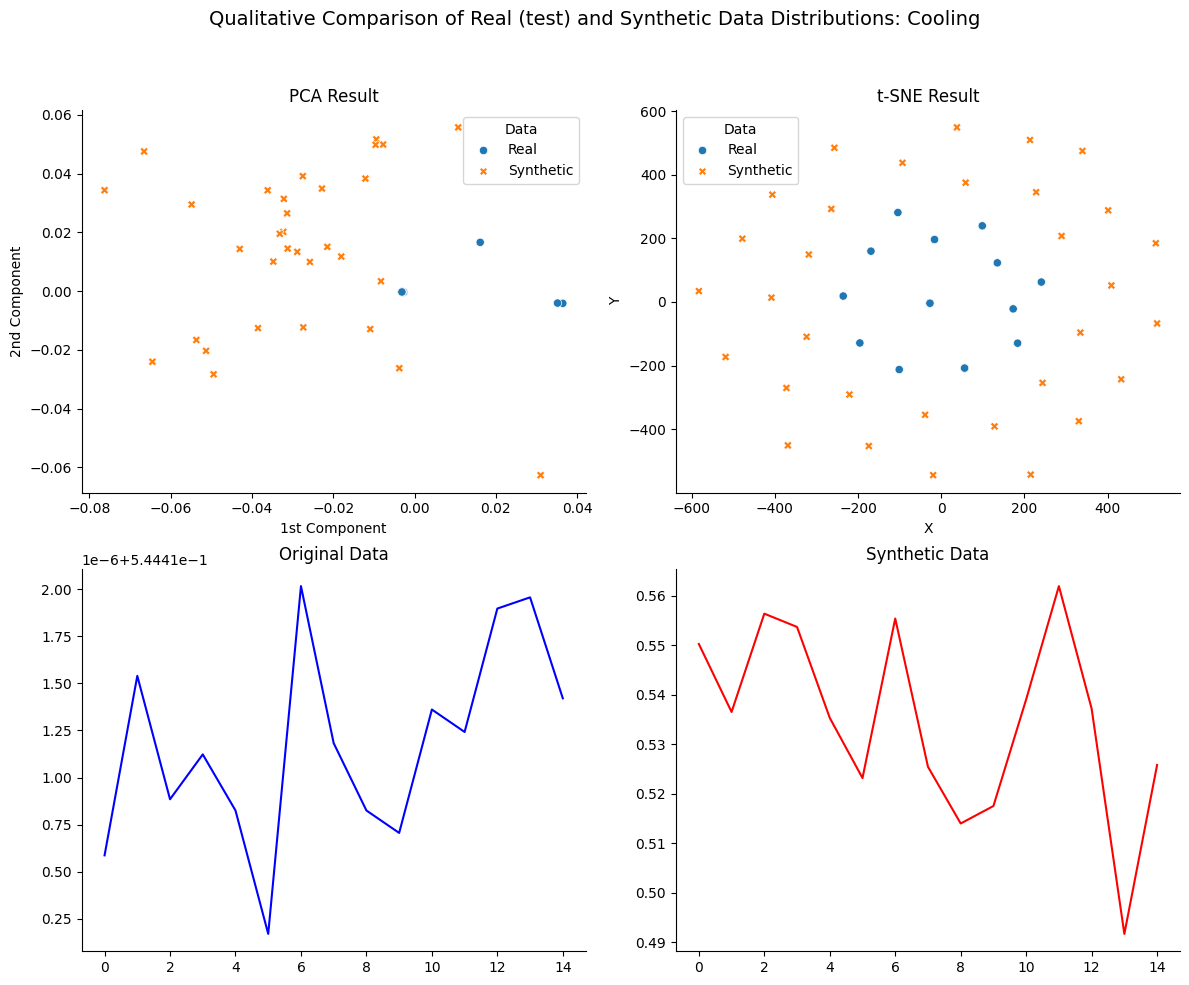

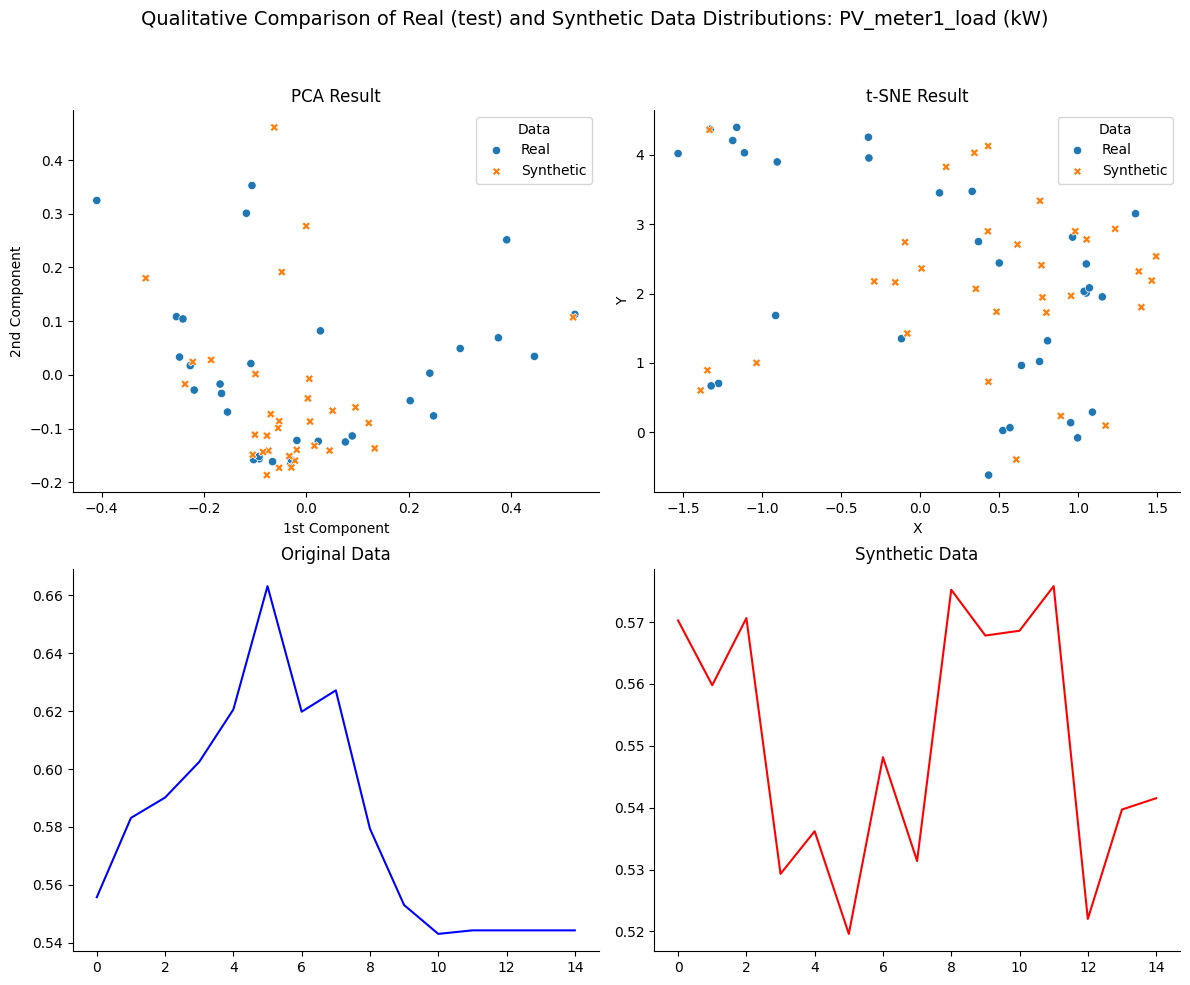

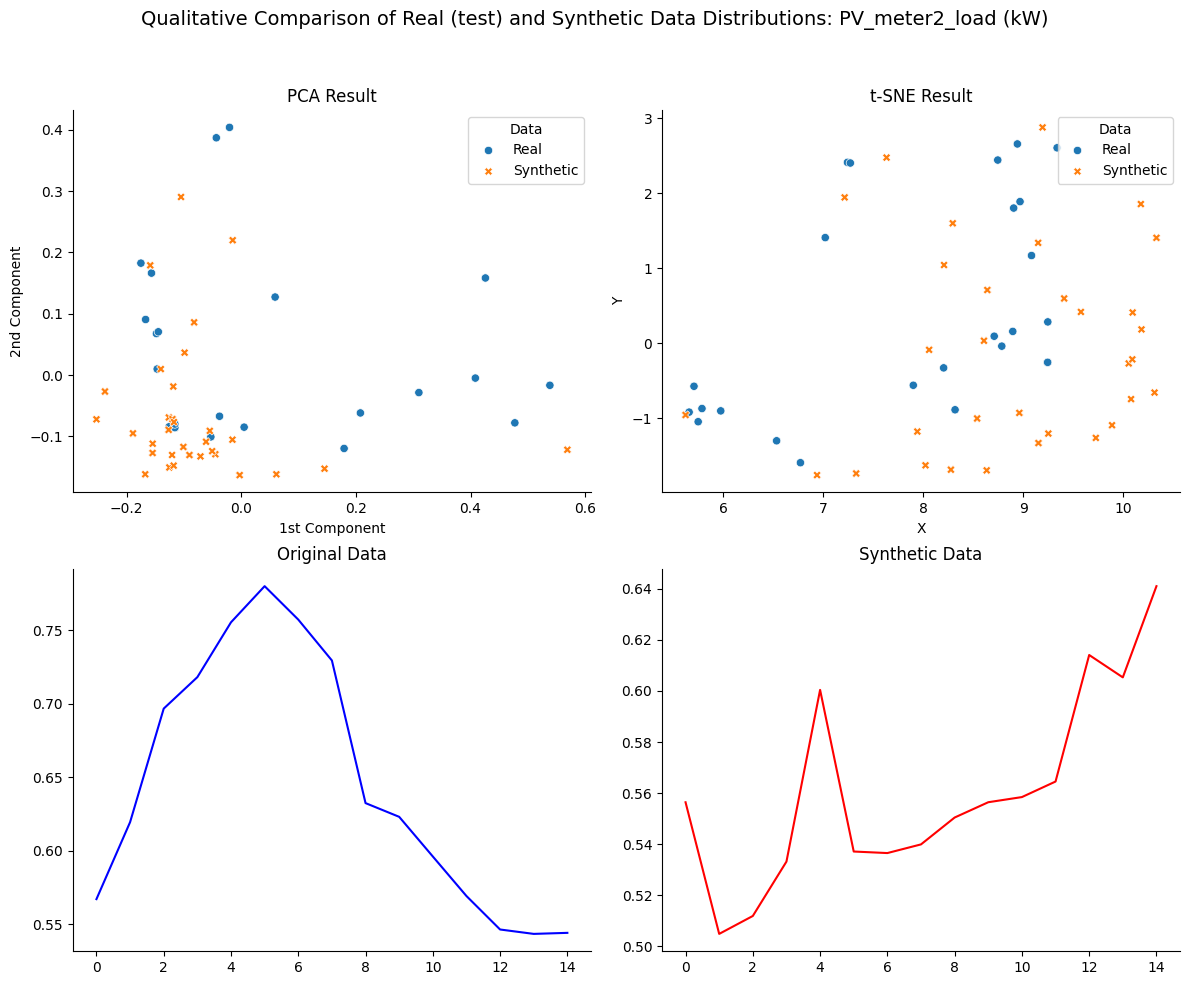

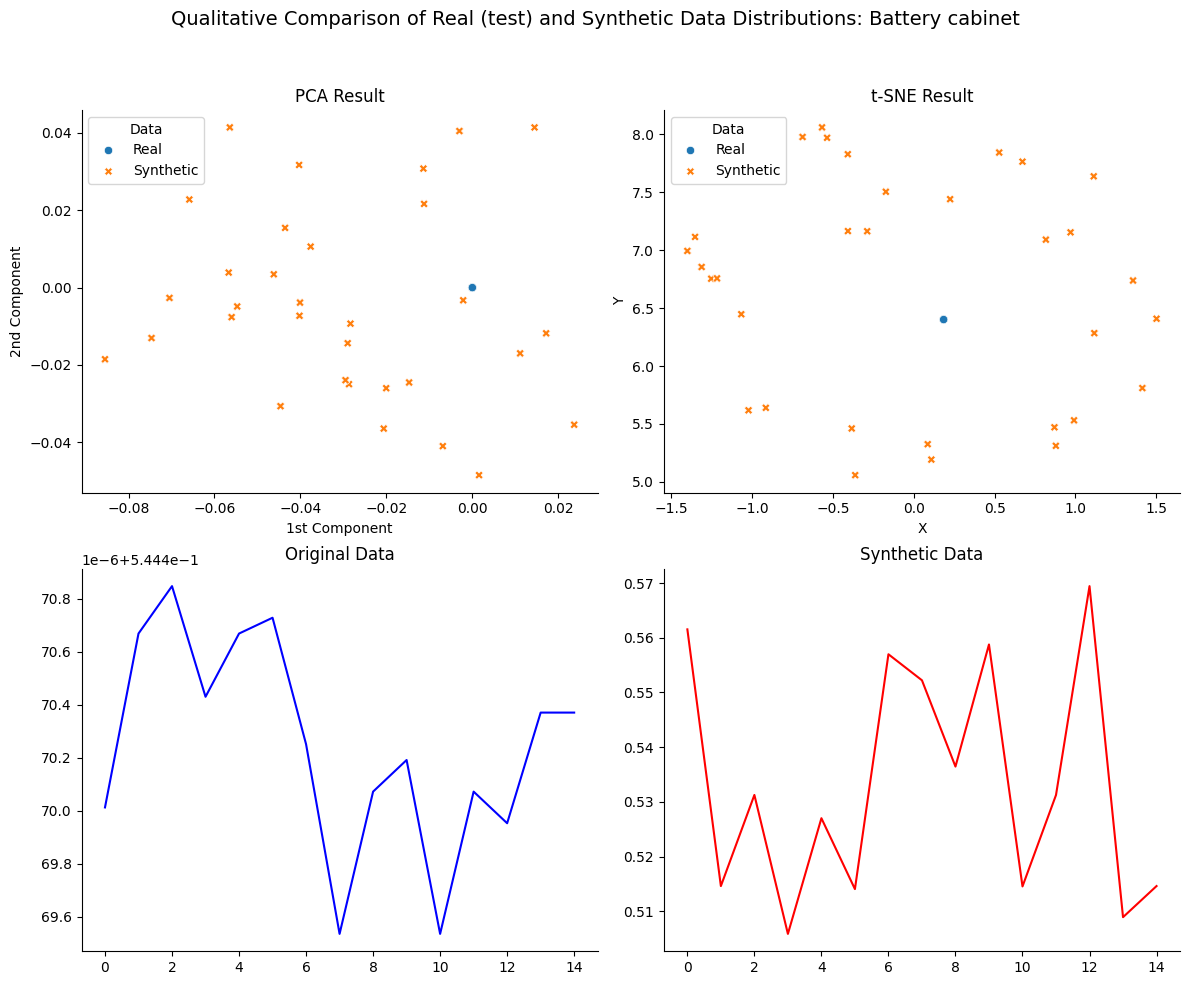

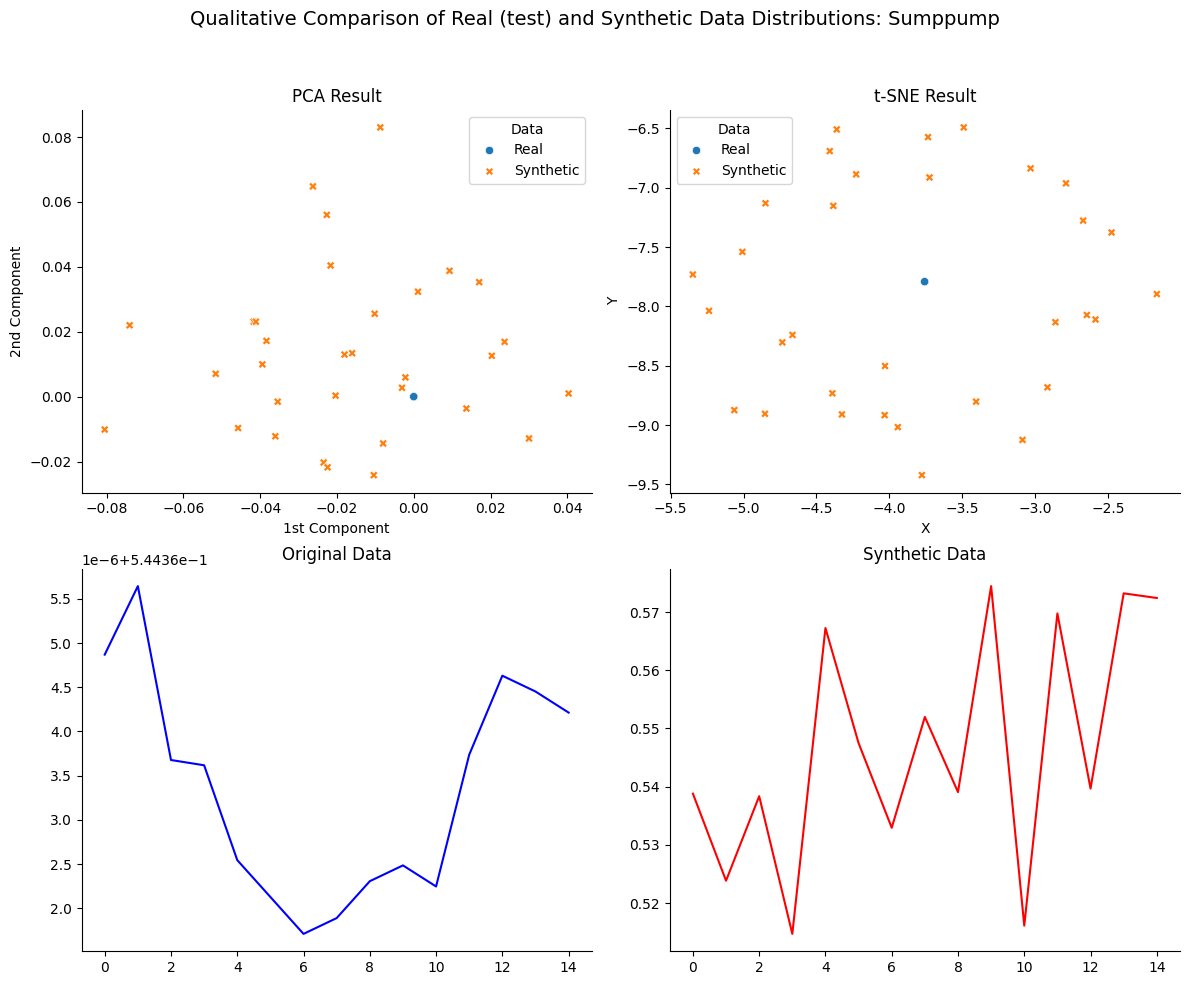

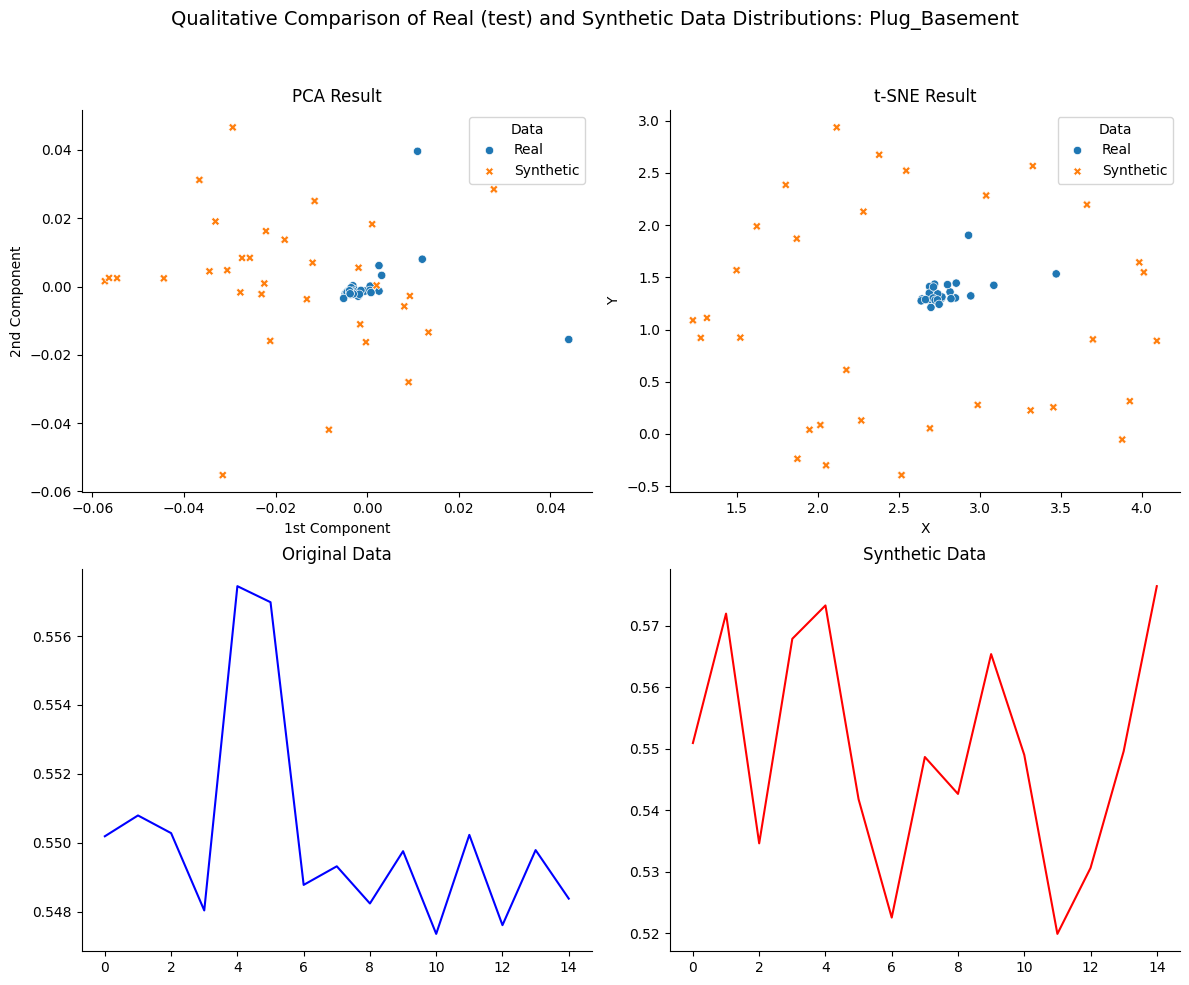

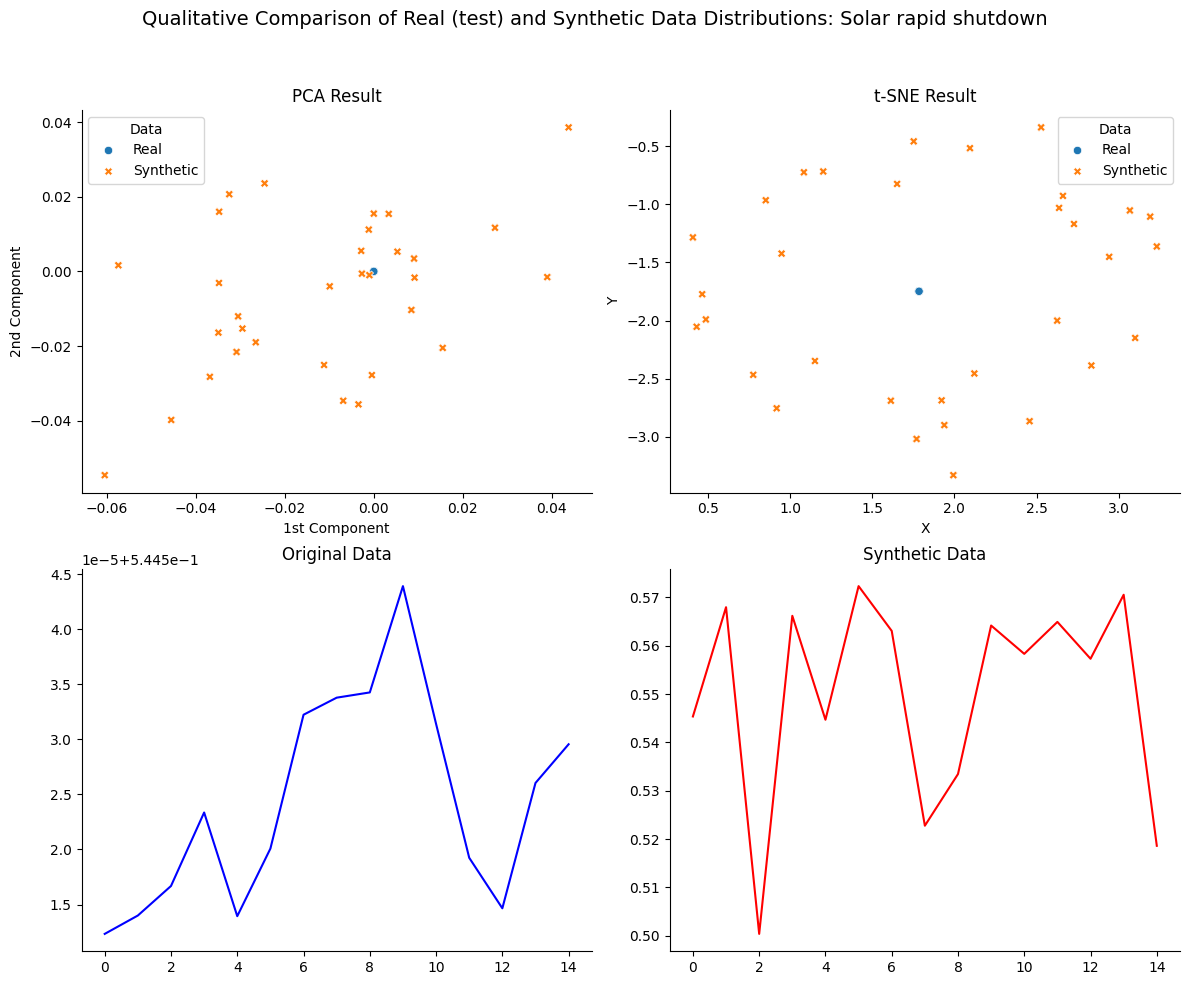

In [15]:
for idx, feature in enumerate(house_zero_feature_subset):
    real_feature = np.expand_dims(real_data_train[:, idx, :].cpu().numpy(), axis=-1)
    gen_feature = np.expand_dims(cond_samples_test[:, :, idx], axis=-1)
    
    visualize_pca_tsne(ori_data=real_feature, fake_data=gen_feature, seq_len=seq_len, train_test="test", filename=log_file_name, cond=True, feature=feature)

### Jensen-Shannon Divergence

In [16]:
train_jsd_con_list = []
test_jsd_con_list = []

for idx, feature in enumerate(house_zero_feature_subset):
    real_feature_train = real_data_train[:, idx, :].cpu().numpy()
    real_feature_test = real_data_test[:, idx, :].cpu().numpy()
    gen_feature_train = cond_samples_train[:, :, idx]
    gen_feature_test = cond_samples_test[:, :, idx]
    
    jsd_con_train = compute_jsd(real_feature_train, gen_feature_train)
    jsd_con_test = compute_jsd(real_feature_test, gen_feature_test)
    
    train_jsd_con_list.append(jsd_con_train)
    test_jsd_con_list.append(jsd_con_test)

## Viz

In [17]:
data = {
    "train_jsd_con": train_jsd_con_list,
    "train_jsd_no_con": train_jsd_no_con_list,
    "test_jsd_con": test_jsd_con_list,
    "test_jsd_no_con": test_jsd_no_con_list
}

jsd_data = pd.DataFrame(data, index=house_zero_feature_subset)
jsd_data.head()


train_jsd_con  train_jsd_no_con  test_jsd_con  \
NET                       0.395313          0.806369      0.391544   
Cooling                   0.987329          0.994373      0.990321   
PV_meter1_load (kW)       0.687502          0.892066      0.715849   
PV_meter2_load (kW)       0.762148          0.896559      0.783894   
Battery cabinet           0.953157          0.967400      0.961236   

                     test_jsd_no_con  
NET                         0.810909  
Cooling                     0.997493  
PV_meter1_load (kW)         0.872488  
PV_meter2_load (kW)         0.897078  
Battery cabinet             0.978447

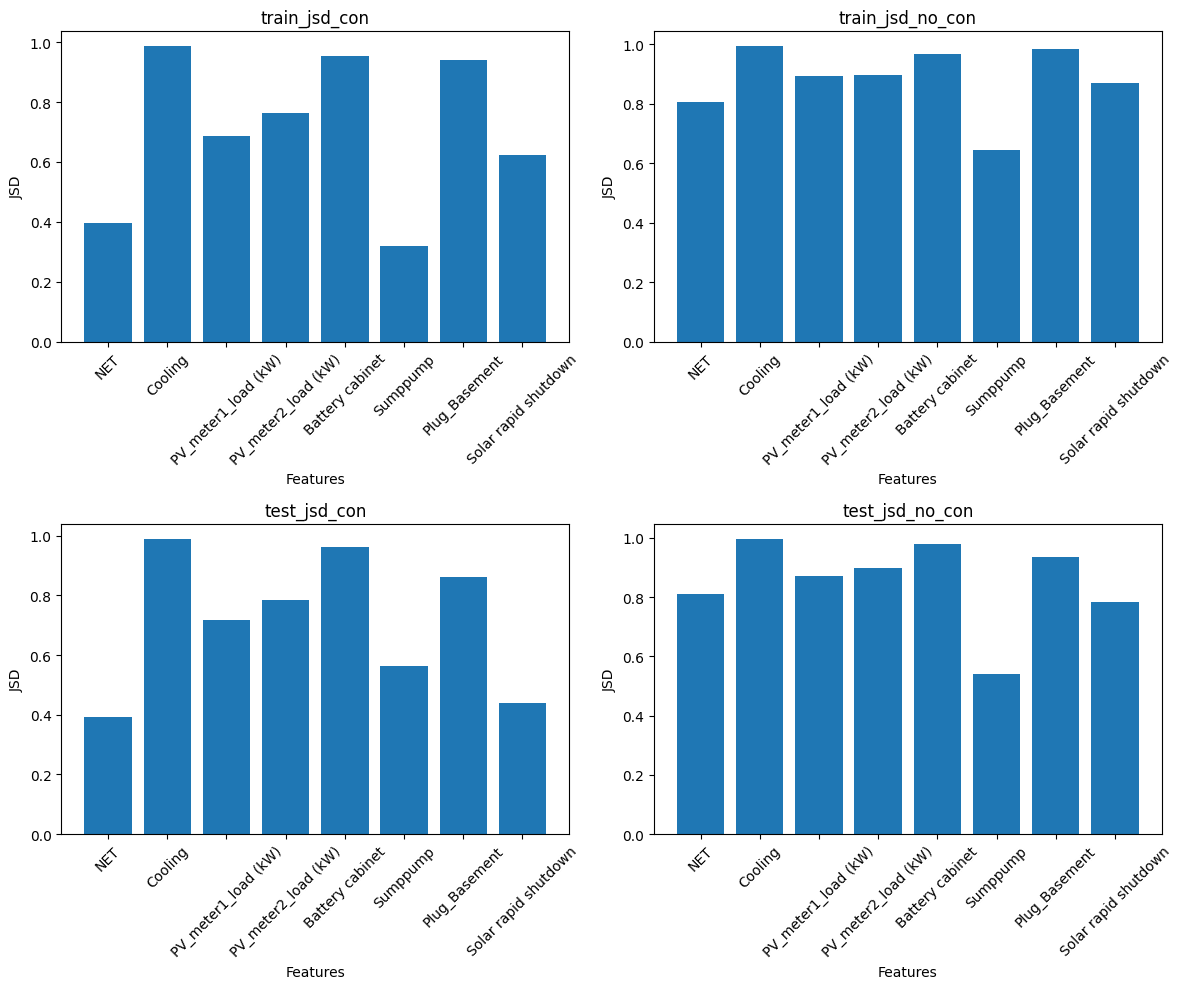

In [18]:
plot_dir = f'./logging/plots/JSD/'

if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axs = axs.flatten()

for i, column in enumerate(jsd_data.columns):
    axs[i].bar(jsd_data.index, jsd_data[column])
    axs[i].set_title(column)
    axs[i].set_xlabel('Features')
    axs[i].set_ylabel('JSD')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, log_file_name+".png", ))
plt.show()

# Logging

In [19]:
log_dir = "./logging/logs"
log_file_path = os.path.join(log_dir, log_file_name + ".txt")

jsd_data.to_csv(os.path.join(log_dir, log_file_name + ".csv"))

with open(log_file_path, 'w') as log_file:
    log_file.write("Config:\n")
    for key, value in config.items():
        log_file.write(f"{key}: {value}\n")
    
    log_file.write("\nJSD Values:\n")
    log_file.write(str(os.path.join(log_dir, log_file_name + ".csv")))

print(f"Log file created at: {log_file_path}")

Log file created at: ./logging/logs\TransEncoder_fft_2025-02-27-17-17.txt


In [20]:
#best_model = torch.load("./logging/weights/TransEncoder_te_2025-02-19-19-39/best_model_weights.pth")